In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [6]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
all_files = glob.glob(os.path.join(path, "*.json"))

In [7]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [8]:
for types in df.type.unique():
    print(types)
    

Checkout
Oper
Voided
Va
EBT
Tndr
Dept
Reprint


In [9]:
df=df[df['type']=='Checkout']

In [10]:
for term in df.term.unique():
    print(term)
    

11
6
5
10
8
1
3
4
2
7
9


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [11]:
df=df[df['term']<10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 15 to 3030
Data columns (total 10 columns):
date      63802 non-null object
gross+    63802 non-null float64
gross-    63802 non-null float64
items     63802 non-null object
net       63802 non-null float64
oper      63802 non-null int64
term      63802 non-null int64
time      63802 non-null object
trans     63802 non-null int64
type      63802 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 5.4+ MB


In [12]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [13]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [14]:
pickle.dump(df,open('./pickles/df.p','wb'))

In [2]:
df = pickle.load(open('./pickles/df.p','rb'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 15 to 3030
Data columns (total 12 columns):
date           63802 non-null datetime64[ns]
gross+         63802 non-null float64
gross-         63802 non-null float64
items          63802 non-null object
net            63802 non-null float64
oper           63802 non-null int64
term           63802 non-null int64
time           63802 non-null object
trans          63802 non-null int64
type           63802 non-null object
day_of_week    63802 non-null object
month          63802 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 6.3+ MB


In [17]:
quarter1 = df[(df['month']>=1) & (df['month']<=3)]

In [18]:
for month in range(1,13):
    print(month)
    
    #df = df[(df['month']==10)]

1
2
3
4
5
6
7
8
9
10
11
12


## Import just one day into a dataframe 

In [19]:
#df=pd.read_json('./jsons/1.json',keep_default_dates=False,lines=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63802 entries, 15 to 3030
Data columns (total 12 columns):
date           63802 non-null datetime64[ns]
gross+         63802 non-null float64
gross-         63802 non-null float64
items          63802 non-null object
net            63802 non-null float64
oper           63802 non-null int64
term           63802 non-null int64
time           63802 non-null object
trans          63802 non-null int64
type           63802 non-null object
day_of_week    63802 non-null object
month          63802 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 6.3+ MB


In [4]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale','PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    
    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords) )  
    stopwords = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords:
        items_set.remove(stops)
  
    print("yay")
    return items_set,stopwords, item_dict, basket_counts

items_set, stopwords, item_dict, basket_counts = get_items(df,most_common=5,least_common=5)

<class 'list'>
yay


In [5]:
Counter(item_dict).most_common(25)

[('BAG CREDIT', 57248),
 ('SF Bag Charge', 15437),
 ('SMALL COOLER CRV', 12381),
 ('BANANAS', 9684),
 ('AVOCADOS HASS', 6816),
 ('ONIONS YELLOW', 6076),
 ('APPLES FUJI', 4994),
 ('8 OZ BIO TUB t3', 4917),
 ('GARLIC WHITE', 4262),
 ('CRV SMALL SING T', 3990),
 ('CRV LRG SING NOTAX', 3957),
 ('CELERY', 3627),
 ('CRV SMALL NO TAX', 3542),
 ('16OZ BIO TUB t4', 3453),
 ('PEPPERS RED BELL', 3397),
 ('KALE DINO', 3363),
 ('ORANGES NAVEL', 3349),
 ('CARROTS LOOSE', 3253),
 ('GINGER', 3157),
 ('LEMONS', 3106),
 ('BOTTLE DEPOSIT', 2971),
 ('SQUASH ZUCCHINI', 2958),
 ('LARGE COOLER CRV', 2943),
 ('CILANTRO', 2936),
 ('BEER SMALL CRV', 2857)]

In [6]:
df['item_count']=basket_counts

In [7]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [8]:
q1,q2,q3

(4.0, 9.0, 17.0)

In [783]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [785]:
#df = df_avg

In [9]:
df['item_count'].max()

156

In [10]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [11]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [12]:
df.index

Int64Index([  15,   20,   21,   23,   24,   25,   27,   28,   29,   30,
            ...
            3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030],
           dtype='int64', length=63802)

In [13]:
df=df.reset_index()

In [14]:
df.index

RangeIndex(start=0, stop=63802, step=1)

In [15]:
df.describe()

index        gross+        gross-           net          oper  \
count  63802.000000  63802.000000  63802.000000  63802.000000  63802.000000   
mean    1330.222642     68.214704      1.932186     66.282518     53.296574   
std      773.187654    100.188073     65.924949     73.778446     27.062402   
min        3.000000      0.000000      0.000000   -167.520000      8.000000   
25%      666.000000     18.970000      0.000000     18.650000     26.000000   
50%     1315.000000     44.330000      0.000000     43.705000     55.000000   
75%     1969.000000     90.047500      0.000000     88.567500     79.000000   
max     3113.000000   7667.980000   7538.640000   2387.560000    104.000000   

               term         trans    month  total_of_items    item_count  
count  63802.000000  63802.000000  63802.0         63802.0  63802.000000  
mean       4.311902    155.572176      2.0             0.0     12.389329  
std        2.512461    106.709467      0.0             0.0     11.806651  
min        1.000000      1.000000      2.0             0.0      0.000000  
25%        2.000000     69.000000      2.0             0.0      4.000000  
50%        4.000000    141.000000      2.0             0.0      9.000000  
75%        6.000000    224.000000      2.0             0.0     17.000000  
max        9.000000    582.000000      2.0             0.0    156.000000

In [16]:
df.pop('index')
print ()

In [17]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63802 entries, 0 to 63801
Data columns (total 14 columns):
date              63802 non-null datetime64[ns]
gross+            63802 non-null float64
gross-            63802 non-null float64
items             63802 non-null object
net               63802 non-null float64
oper              63802 non-null int64
term              63802 non-null int64
time              63802 non-null object
trans             63802 non-null int64
type              63802 non-null object
day_of_week       63802 non-null object
month             63802 non-null int64
total_of_items    63802 non-null int64
item_count        63802 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(6), object(4)
memory usage: 6.8+ MB


In [18]:
df.iloc[:,0].index


RangeIndex(start=0, stop=63802, step=1)

In [19]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=63802, step=1)

In [20]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [21]:
col_index_dict['CILANTRO']

3528

In [22]:
matrix = np.zeros(df_items.shape)
matrix.shape

(63802, 13028)

In [27]:
    matrix_dict = defaultdict(int)
    for i in range(df.shape[0]):
        for item in df['items'][i]:
            #set matrix to boolean for item precence in basket:
            if item[1] not in stopwords:
                if item[2] > 0:
                    value = 1
                elif item[2] == 0:
                    value = 0
                else:
                    value = -1
                matrix_dict[(i,col_index_dict[item[1]])] += value
                matrix[i,col_index_dict[ item[1] ]] = matrix[i,col_index_dict[ item[1] ]] + value
            '''if item[1] not in stopwords and item[2] > 0:
                matrix[i,col_index_dict[ item[1] ]] = 1
            if item[1] not in stopwords and item[2] < 0:
                matrix[i,col_index_dict[ item[1] ]] = 0'''
    #matrix = (matrix > 0).astype(int)
 

In [50]:
df[0:1]

date  gross+  gross-  \
0 2019-02-01    1.75     0.0   

                                               items   net  oper  term   time  \
0  [[, Q KOLA, 1.5899999999999999, 15], [, CRV SM...  1.75    42     6  08:57   

   trans      type day_of_week  month  total_of_items  item_count  
0      2  Checkout      Friday      2               0           3

In [28]:
sparse_matrix = sparse.csr_matrix(matrix)

In [45]:
matrix_dict

defaultdict(int,
            {(0, 1193): 1,
             (0, 1334): -1,
             (1, 1334): -1,
             (2, 13012): 1,
             (2, 5960): 1,
             (2, 8978): 1,
             (3, 12418): 1,
             (3, 12629): 1,
             (3, 945): 1,
             (3, 11192): -1,
             (3, 11899): -1,
             (3, 10590): -1,
             (4, 6022): 1,
             (4, 5252): 1,
             (4, 5608): 1,
             (5, 11972): 1,
             (5, 9151): 2,
             (5, 7215): 1,
             (5, 6685): 1,
             (5, 7506): 1,
             (5, 3029): 1,
             (5, 6177): 1,
             (6, 9820): 1,
             (6, 7396): 1,
             (6, 8888): 1,
             (7, 280): 1,
             (7, 1273): 1,
             (7, 3569): 1,
             (7, 3625): 3,
             (7, 7682): 1,
             (8, 8719): 1,
             (9, 1948): 2,
             (9, 8978): 2,
             (9, 12972): 1,
             (10, 2803): 1,
             (11, 2579): 1

In [44]:
for s in sparse_matrix:
    print(s)

  (0, 1193)	1

  (0, 5960)	1
  (0, 8978)	1
  (0, 13012)	1
  (0, 945)	1
  (0, 12418)	1
  (0, 12629)	1
  (0, 5252)	1
  (0, 5608)	1
  (0, 6022)	1
  (0, 3029)	1
  (0, 6177)	1
  (0, 6685)	1
  (0, 7215)	1
  (0, 7506)	1
  (0, 9151)	1
  (0, 11972)	1
  (0, 7396)	1
  (0, 8888)	1
  (0, 9820)	1
  (0, 280)	1
  (0, 1273)	1
  (0, 3569)	1
  (0, 3625)	1
  (0, 7682)	1
  (0, 8719)	1
  (0, 1948)	1
  (0, 8978)	1
  (0, 12972)	1
  (0, 2803)	1
  (0, 2579)	1
  (0, 9242)	1
  (0, 10916)	1
  (0, 11370)	1
  (0, 366)	1
  (0, 558)	1
  (0, 567)	1
  (0, 681)	1
  (0, 3638)	1
  (0, 4977)	1
  (0, 1790)	1
  (0, 3711)	1
  (0, 5321)	1
  (0, 10442)	1
  (0, 10944)	1
  (0, 2464)	1
  (0, 7825)	1
  (0, 11732)	1
  (0, 10058)	1
  (0, 11336)	1
  (0, 12204)	1
  (0, 931)	1
  (0, 1834)	1
  (0, 3219)	1
  (0, 4636)	1
  (0, 6147)	1
  (0, 7161)	1
  (0, 8628)	1
  (0, 6120)	1
  (0, 1413)	1
  (0, 2905)	1
  (0, 3020)	1
  (0, 6284)	1
  (0, 7606)	1
  (0, 9843)	1
  (0, 11404)	1
  (0, 6)	1
  (0, 512)	1
  (0, 671)	1
  (0, 874)	1
  (0, 3457)	1
  (0

  (0, 133)	1
  (0, 885)	1
  (0, 1593)	1
  (0, 2010)	1
  (0, 5417)	1
  (0, 5659)	1
  (0, 7185)	1
  (0, 8456)	1
  (0, 8715)	1
  (0, 11886)	1
  (0, 11911)	1
  (0, 12047)	1
  (0, 12109)	1
  (0, 12276)	1
  (0, 12310)	1
  (0, 12419)	1
  (0, 7812)	1
  (0, 343)	1
  (0, 732)	1
  (0, 752)	1
  (0, 1717)	1
  (0, 2553)	1
  (0, 2592)	1
  (0, 4108)	1
  (0, 5236)	1
  (0, 5368)	1
  (0, 5402)	1
  (0, 5776)	1
  (0, 6187)	1
  (0, 7098)	1
  (0, 7730)	1
  (0, 7813)	1
  (0, 8618)	1
  (0, 8984)	1
  (0, 9855)	1
  (0, 10190)	1
  (0, 10672)	1
  (0, 10916)	1
  (0, 10948)	1
  (0, 11531)	1
  (0, 11886)	1
  (0, 12225)	1
  (0, 1146)	1
  (0, 2848)	1
  (0, 3723)	1
  (0, 7060)	1
  (0, 8468)	1
  (0, 9657)	1
  (0, 9759)	1
  (0, 9964)	1
  (0, 10294)	1
  (0, 11018)	1
  (0, 142)	1
  (0, 6685)	1
  (0, 6819)	1
  (0, 7506)	1
  (0, 7509)	1
  (0, 9083)	1
  (0, 9351)	1
  (0, 11404)	1
  (0, 945)	1
  (0, 1946)	1
  (0, 2065)	1
  (0, 3102)	1
  (0, 5474)	1
  (0, 9380)	1
  (0, 10466)	1
  (0, 10890)	1
  (0, 11886)	1
  (0, 12230)	1
  (0, 

  (0, 2298)	1
  (0, 6003)	1
  (0, 8048)	1
  (0, 11215)	1
  (0, 11324)	1
  (0, 752)	1
  (0, 1204)	1
  (0, 7203)	1
  (0, 1397)	1
  (0, 2888)	1
  (0, 3528)	1
  (0, 4766)	1
  (0, 4896)	1
  (0, 6961)	1
  (0, 7015)	1
  (0, 8885)	1
  (0, 9242)	1
  (0, 10890)	1
  (0, 11121)	1
  (0, 12335)	1
  (0, 43)	1
  (0, 157)	1
  (0, 280)	1
  (0, 732)	1
  (0, 752)	1
  (0, 774)	1
  (0, 919)	1
  (0, 1048)	1
  (0, 1224)	1
  (0, 1705)	1
  (0, 2448)	1
  (0, 2546)	1
  (0, 2879)	1
  (0, 4479)	1
  (0, 4956)	1
  (0, 6140)	1
  (0, 6538)	1
  (0, 7218)	1
  (0, 7506)	1
  (0, 8141)	1
  (0, 8800)	1
  (0, 10820)	1
  (0, 11404)	1
  (0, 11526)	1
  (0, 11540)	1
  (0, 11673)	1
  (0, 12354)	1
  (0, 12549)	1
  (0, 12759)	1
  (0, 12814)	1

  (0, 1049)	1
  (0, 1642)	1
  (0, 2579)	1
  (0, 3528)	1
  (0, 4485)	1
  (0, 5379)	1
  (0, 6258)	1
  (0, 6284)	1
  (0, 6637)	1
  (0, 6685)	1
  (0, 6726)	1
  (0, 7537)	1
  (0, 10486)	1
  (0, 11576)	1
  (0, 11944)	1
  (0, 702)	1
  (0, 2185)	1
  (0, 2866)	1
  (0, 4767)	1
  (0, 7347)	1
  (0, 7615)	

  (0, 12645)	1
  (0, 1402)	1
  (0, 1948)	1
  (0, 3268)	1
  (0, 3528)	1
  (0, 4524)	1
  (0, 4691)	1
  (0, 7485)	1
  (0, 7672)	1
  (0, 7753)	1
  (0, 8289)	1
  (0, 8547)	1
  (0, 8928)	1
  (0, 9089)	1
  (0, 9242)	1
  (0, 11121)	1
  (0, 11886)	1
  (0, 4833)	1
  (0, 6201)	1
  (0, 12422)	1
  (0, 213)	1
  (0, 1037)	1
  (0, 2352)	1
  (0, 2841)	1
  (0, 3796)	1
  (0, 3816)	1
  (0, 4271)	1
  (0, 5776)	1
  (0, 8306)	1
  (0, 11287)	1
  (0, 11890)	1
  (0, 12851)	1
  (0, 159)	1
  (0, 1761)	1
  (0, 1834)	1
  (0, 4547)	1
  (0, 5051)	1
  (0, 5776)	1
  (0, 8567)	1
  (0, 9717)	1
  (0, 10515)	1
  (0, 10980)	1
  (0, 11404)	1

  (0, 2858)	1
  (0, 5816)	1
  (0, 11163)	1
  (0, 12979)	1
  (0, 4486)	1
  (0, 6902)	1
  (0, 9100)	1
  (0, 10088)	1
  (0, 12935)	1
  (0, 366)	1
  (0, 774)	1
  (0, 1139)	1
  (0, 1642)	1
  (0, 3536)	1
  (0, 3580)	1
  (0, 3714)	1
  (0, 3757)	1
  (0, 4556)	1
  (0, 4789)	1
  (0, 5954)	1
  (0, 6329)	1
  (0, 6643)	1
  (0, 7497)	1
  (0, 9083)	1
  (0, 9293)	1
  (0, 10629)	1
  (0, 11404)	1
  (0, 1


  (0, 1611)	1
  (0, 2797)	1
  (0, 3407)	1
  (0, 3524)	1
  (0, 4606)	1
  (0, 4939)	1
  (0, 5062)	1
  (0, 7415)	1
  (0, 7497)	1
  (0, 9744)	1
  (0, 10906)	1
  (0, 10998)	1
  (0, 12062)	1
  (0, 6)	1
  (0, 13)	1
  (0, 713)	1
  (0, 1260)	1
  (0, 1834)	1
  (0, 3051)	1
  (0, 3269)	1
  (0, 4067)	1
  (0, 4635)	1
  (0, 5278)	1
  (0, 5428)	1
  (0, 5609)	1
  (0, 5720)	1
  (0, 5776)	1
  (0, 6483)	1
  (0, 6598)	1
  (0, 9643)	1
  (0, 10310)	1
  (0, 12322)	1
  (0, 12549)	1
  (0, 5039)	1
  (0, 9661)	1
  (0, 10358)	1
  (0, 11034)	1
  (0, 903)	1
  (0, 2129)	1
  (0, 2670)	1
  (0, 3759)	1
  (0, 5265)	1
  (0, 6177)	1
  (0, 7608)	1
  (0, 7737)	1
  (0, 8901)	1
  (0, 9645)	1
  (0, 10124)	1
  (0, 238)	1
  (0, 4635)	1
  (0, 10436)	1
  (0, 284)	1
  (0, 428)	1
  (0, 1700)	1
  (0, 2749)	1
  (0, 4962)	1
  (0, 6110)	1
  (0, 6177)	1
  (0, 6423)	1
  (0, 11803)	1
  (0, 12795)	1
  (0, 1182)	1
  (0, 2997)	1
  (0, 4159)	1
  (0, 4283)	1
  (0, 4556)	1
  (0, 4691)	1
  (0, 4881)	1
  (0, 6538)	1
  (0, 6685)	1
  (0, 9251)	1
  (

  (0, 10951)	1
  (0, 253)	1
  (0, 303)	1
  (0, 5081)	1
  (0, 5719)	1
  (0, 7967)	1
  (0, 8317)	1
  (0, 9079)	1
  (0, 10253)	1
  (0, 12158)	1
  (0, 142)	1
  (0, 235)	1
  (0, 580)	1
  (0, 762)	1
  (0, 1415)	1
  (0, 1920)	1
  (0, 1946)	1
  (0, 2089)	1
  (0, 3528)	1
  (0, 3679)	1
  (0, 4962)	1
  (0, 5076)	1
  (0, 5121)	1
  (0, 5609)	1
  (0, 5699)	1
  (0, 5925)	1
  (0, 5954)	1
  (0, 6243)	1
  (0, 6367)	1
  (0, 6726)	1
  (0, 6997)	1
  (0, 7341)	1
  (0, 7672)	1
  (0, 7768)	1
  (0, 8012)	1
  (0, 8090)	1
  (0, 8265)	1
  (0, 8359)	1
  (0, 8511)	1
  (0, 9563)	1
  (0, 10558)	1
  (0, 10916)	1
  (0, 10980)	1
  (0, 11455)	1
  (0, 11911)	1
  (0, 12209)	1
  (0, 12629)	1
  (0, 2287)	1
  (0, 11107)	1
  (0, 2852)	1
  (0, 2869)	1
  (0, 4521)	1
  (0, 5252)	1
  (0, 6620)	1
  (0, 6785)	1
  (0, 6807)	1
  (0, 7813)	1
  (0, 10423)	1
  (0, 12391)	1
  (0, 12841)	1
  (0, 4786)	1
  (0, 11683)	1

  (0, 78)	1
  (0, 1030)	1
  (0, 1797)	1
  (0, 1948)	1
  (0, 2733)	1
  (0, 3281)	1
  (0, 3457)	1
  (0, 3976)	1
  (0, 4412)	

  (0, 12629)	1
  (0, 494)	1
  (0, 774)	1
  (0, 1056)	1
  (0, 1797)	1
  (0, 2869)	1
  (0, 3138)	1
  (0, 4342)	1
  (0, 4556)	1
  (0, 4813)	1
  (0, 4962)	1
  (0, 5368)	1
  (0, 5986)	1
  (0, 6329)	1
  (0, 6726)	1
  (0, 7407)	1
  (0, 7859)	1
  (0, 8198)	1
  (0, 9083)	1
  (0, 9351)	1
  (0, 10629)	1
  (0, 10665)	1
  (0, 10671)	1
  (0, 11264)	1
  (0, 11909)	1
  (0, 12209)	1
  (0, 12549)	1
  (0, 12956)	1
  (0, 1642)	1
  (0, 3831)	1
  (0, 4962)	1
  (0, 5163)	1
  (0, 8511)	1
  (0, 10554)	1
  (0, 10730)	1
  (0, 4228)	1
  (0, 7185)	1
  (0, 8289)	1
  (0, 8757)	1
  (0, 9274)	1
  (0, 10474)	1
  (0, 10891)	1
  (0, 11121)	1
  (0, 11886)	1
  (0, 12529)	1
  (0, 634)	1
  (0, 2398)	1
  (0, 3397)	1
  (0, 4389)	1
  (0, 4968)	1
  (0, 10890)	1
  (0, 11121)	1
  (0, 11279)	1
  (0, 12310)	1
  (0, 882)	1
  (0, 4556)	1
  (0, 8748)	1
  (0, 12513)	1
  (0, 5037)	1
  (0, 11460)	1
  (0, 2158)	1
  (0, 3666)	1
  (0, 4175)	1
  (0, 4199)	1
  (0, 4283)	1
  (0, 5045)	1
  (0, 6227)	1
  (0, 8668)	1
  (0, 9089)	1
  (0, 11263)	1
 

  (0, 5544)	1
  (0, 13)	1
  (0, 3003)	1
  (0, 3021)	1
  (0, 7417)	1
  (0, 10891)	1
  (0, 11756)	1
  (0, 11865)	1
  (0, 12866)	1
  (0, 1289)	1
  (0, 2185)	1
  (0, 6910)	1
  (0, 7270)	1
  (0, 8496)	1
  (0, 9429)	1
  (0, 9523)	1
  (0, 10595)	1
  (0, 12915)	1
  (0, 276)	1
  (0, 732)	1
  (0, 4105)	1
  (0, 4962)	1
  (0, 10980)	1
  (0, 5266)	1
  (0, 6178)	1
  (0, 7951)	1
  (0, 12881)	1
  (0, 2515)	1
  (0, 4485)	1
  (0, 8105)	1
  (0, 12819)	1
  (0, 4681)	1
  (0, 2803)	1
  (0, 5514)	1
  (0, 12310)	1
  (0, 2271)	1
  (0, 3021)	1
  (0, 4499)	1
  (0, 4844)	1
  (0, 6731)	1
  (0, 7169)	1
  (0, 7332)	1
  (0, 7506)	1
  (0, 8511)	1
  (0, 10867)	1
  (0, 10980)	1
  (0, 11816)	1
  (0, 11886)	1
  (0, 12451)	1
  (0, 39)	1
  (0, 752)	1
  (0, 945)	1
  (0, 1238)	1
  (0, 1642)	1
  (0, 1655)	1
  (0, 2178)	1
  (0, 2311)	1
  (0, 2615)	1
  (0, 2758)	1
  (0, 2888)	1
  (0, 3421)	1
  (0, 3604)	1
  (0, 3656)	1
  (0, 4398)	1
  (0, 4556)	1
  (0, 4767)	1
  (0, 4844)	1
  (0, 4866)	1
  (0, 5018)	1
  (0, 5380)	1
  (0, 6709)	1

  (0, 239)	1
  (0, 433)	1
  (0, 740)	1
  (0, 945)	1
  (0, 1057)	1
  (0, 1655)	1
  (0, 2349)	1
  (0, 4200)	1
  (0, 4691)	1
  (0, 4766)	1
  (0, 5411)	1
  (0, 6177)	1
  (0, 6195)	1
  (0, 6819)	1
  (0, 7248)	1
  (0, 7918)	1
  (0, 8211)	1
  (0, 8496)	1
  (0, 8757)	1
  (0, 8830)	1
  (0, 8901)	1
  (0, 8975)	1
  (0, 9089)	1
  (0, 9380)	1
  (0, 9825)	1
  (0, 10055)	1
  (0, 10629)	1
  (0, 10916)	1
  (0, 10980)	1
  (0, 10998)	1
  (0, 11073)	1
  (0, 11121)	1
  (0, 11307)	1
  (0, 11964)	1
  (0, 2097)	1
  (0, 3744)	1
  (0, 5319)	1
  (0, 5736)	1
  (0, 6029)	1
  (0, 6340)	1
  (0, 8787)	1
  (0, 8901)	1
  (0, 9388)	1
  (0, 10743)	1
  (0, 13019)	1
  (0, 2765)	1
  (0, 2878)	1
  (0, 6390)	1
  (0, 6417)	1
  (0, 7193)	1
  (0, 7497)	1
  (0, 10680)	1
  (0, 10812)	1
  (0, 10908)	1
  (0, 10716)	1
  (0, 11121)	1
  (0, 11560)	1
  (0, 1003)	1
  (0, 12109)	1
  (0, 12310)	1
  (0, 6333)	1
  (0, 8456)	1
  (0, 609)	1
  (0, 1901)	1
  (0, 4323)	1
  (0, 5790)	1
  (0, 5829)	1
  (0, 9368)	1
  (0, 9740)	1
  (0, 218)	1
  (0, 8

  (0, 12549)	1
  (0, 8164)	1
  (0, 12236)	1
  (0, 250)	1
  (0, 1834)	1
  (0, 2714)	1
  (0, 4663)	1
  (0, 4691)	1
  (0, 7984)	1
  (0, 8699)	1
  (0, 9083)	1
  (0, 11121)	1
  (0, 11404)	1
  (0, 1153)	1
  (0, 1543)	1
  (0, 3102)	1
  (0, 4070)	1
  (0, 4978)	1
  (0, 5810)	1
  (0, 6487)	1
  (0, 9502)	1
  (0, 10911)	1
  (0, 11855)	1
  (0, 7347)	1
  (0, 13)	1
  (0, 1302)	1
  (0, 2816)	1
  (0, 4698)	1
  (0, 5565)	1
  (0, 6947)	1
  (0, 8496)	1
  (0, 8541)	1
  (0, 9242)	1
  (0, 9702)	1
  (0, 10006)	1
  (0, 10742)	1
  (0, 10877)	1
  (0, 10890)	1
  (0, 11404)	1
  (0, 11816)	1
  (0, 11886)	1
  (0, 12378)	1
  (0, 12386)	1
  (0, 201)	1
  (0, 2360)	1
  (0, 2660)	1
  (0, 3995)	1
  (0, 4844)	1
  (0, 5362)	1
  (0, 5368)	1
  (0, 6369)	1
  (0, 6680)	1
  (0, 6961)	1
  (0, 8789)	1
  (0, 10890)	1
  (0, 10916)	1
  (0, 12208)	1
  (0, 12506)	1
  (0, 12731)	1
  (0, 1212)	1
  (0, 4962)	1
  (0, 5565)	1
  (0, 6685)	1
  (0, 8289)	1
  (0, 8456)	1
  (0, 10476)	1
  (0, 10595)	1
  (0, 10980)	1
  (0, 4067)	1
  (0, 4762)	1
 

  (0, 353)	1
  (0, 692)	1
  (0, 943)	1
  (0, 2058)	1
  (0, 2415)	1
  (0, 2848)	1
  (0, 2884)	1
  (0, 2991)	1
  (0, 3878)	1
  (0, 4154)	1
  (0, 4208)	1
  (0, 4594)	1
  (0, 5027)	1
  (0, 5120)	1
  (0, 5586)	1
  (0, 5776)	1
  (0, 6815)	1
  (0, 8520)	1
  (0, 9545)	1
  (0, 10190)	1
  (0, 11404)	1
  (0, 11452)	1
  (0, 11531)	1
  (0, 12625)	1
  (0, 2766)	1
  (0, 3525)	1
  (0, 10770)	1
  (0, 11723)	1
  (0, 921)	1
  (0, 2196)	1
  (0, 2304)	1
  (0, 2412)	1
  (0, 2733)	1
  (0, 3699)	1
  (0, 3954)	1
  (0, 6710)	1
  (0, 6980)	1
  (0, 7511)	1
  (0, 7987)	1
  (0, 8607)	1
  (0, 12399)	1
  (0, 12671)	1
  (0, 3508)	1
  (0, 3737)	1
  (0, 8511)	1
  (0, 8705)	1
  (0, 10758)	1
  (0, 12266)	1
  (0, 12348)	1
  (0, 161)	1
  (0, 2345)	1
  (0, 4360)	1
  (0, 5434)	1
  (0, 5912)	1
  (0, 8090)	1
  (0, 8289)	1
  (0, 9083)	1
  (0, 11619)	1
  (0, 3523)	1
  (0, 10884)	1
  (0, 11886)	1

  (0, 2758)	1
  (0, 987)	1
  (0, 2424)	1
  (0, 4294)	1
  (0, 4813)	1
  (0, 6227)	1
  (0, 11198)	1
  (0, 12506)	1
  (0, 12660)	1
  (0, 2

  (0, 8011)	1
  (0, 4813)	1
  (0, 10751)	1
  (0, 419)	1
  (0, 1056)	1
  (0, 1948)	1
  (0, 2242)	1
  (0, 3433)	1
  (0, 4553)	1
  (0, 5368)	1
  (0, 5565)	1
  (0, 5604)	1
  (0, 5776)	1
  (0, 6369)	1
  (0, 6417)	1
  (0, 6516)	1
  (0, 8038)	1
  (0, 8496)	1
  (0, 9725)	1
  (0, 10350)	1
  (0, 10980)	1
  (0, 11723)	1
  (0, 12434)	1
  (0, 12549)	1
  (0, 12941)	1
  (0, 678)	1
  (0, 857)	1
  (0, 1527)	1
  (0, 2235)	1
  (0, 2615)	1
  (0, 2883)	1
  (0, 4180)	1
  (0, 4556)	1
  (0, 4875)	1
  (0, 7021)	1
  (0, 12418)	1
  (0, 737)	1
  (0, 933)	1
  (0, 1834)	1
  (0, 2888)	1
  (0, 3546)	1
  (0, 4389)	1
  (0, 5266)	1
  (0, 6369)	1
  (0, 6799)	1
  (0, 8592)	1
  (0, 9064)	1
  (0, 9835)	1
  (0, 9842)	1
  (0, 10377)	1
  (0, 10399)	1
  (0, 11404)	1
  (0, 12363)	1
  (0, 3945)	1
  (0, 4767)	1
  (0, 5565)	1
  (0, 8470)	1
  (0, 11404)	1
  (0, 11886)	1
  (0, 4767)	1
  (0, 4844)	1
  (0, 5760)	1
  (0, 5776)	1
  (0, 6177)	1
  (0, 6335)	1
  (0, 6369)	1
  (0, 6955)	1
  (0, 10377)	1
  (0, 10980)	1
  (0, 11121)	1
  (0, 11

  (0, 382)	1
  (0, 3219)	1
  (0, 9729)	1
  (0, 11215)	1
  (0, 12423)	1
  (0, 12673)	1
  (0, 1440)	1

  (0, 94)	1
  (0, 129)	1
  (0, 1206)	1
  (0, 1834)	1
  (0, 4452)	1
  (0, 4844)	1
  (0, 4987)	1
  (0, 5776)	1
  (0, 9083)	1
  (0, 10190)	1
  (0, 11121)	1
  (0, 11151)	1
  (0, 1003)	1
  (0, 2086)	1
  (0, 2546)	1
  (0, 3120)	1
  (0, 8511)	1
  (0, 8541)	1
  (0, 8782)	1
  (0, 9281)	1
  (0, 11404)	1
  (0, 11756)	1
  (0, 268)	1
  (0, 3049)	1
  (0, 4980)	1
  (0, 6675)	1
  (0, 7210)	1
  (0, 8131)	1
  (0, 8669)	1
  (0, 9083)	1
  (0, 9711)	1
  (0, 11404)	1

  (0, 941)	1
  (0, 5092)	1
  (0, 5278)	1
  (0, 5937)	1
  (0, 7006)	1
  (0, 9266)	1
  (0, 9563)	1
  (0, 9619)	1
  (0, 9861)	1
  (0, 11658)	1
  (0, 11874)	1
  (0, 201)	1
  (0, 906)	1
  (0, 1727)	1
  (0, 3688)	1
  (0, 5115)	1
  (0, 5719)	1
  (0, 7658)	1
  (0, 8237)	1
  (0, 11259)	1
  (0, 12369)	1
  (0, 428)	1
  (0, 817)	1
  (0, 1376)	1
  (0, 2751)	1
  (0, 2869)	1
  (0, 2993)	1
  (0, 3528)	1
  (0, 4070)	1
  (0, 4399)	1
  (0, 5368)	1
  (0, 5504)	1
 

  (0, 569)	1
  (0, 752)	1
  (0, 1524)	1
  (0, 1725)	1
  (0, 2236)	1
  (0, 2615)	1
  (0, 2692)	1
  (0, 3842)	1
  (0, 4477)	1
  (0, 4767)	1
  (0, 4779)	1
  (0, 5368)	1
  (0, 5623)	1
  (0, 5776)	1
  (0, 6325)	1
  (0, 6685)	1
  (0, 7506)	1
  (0, 8105)	1
  (0, 8757)	1
  (0, 9089)	1
  (0, 11404)	1
  (0, 11768)	1
  (0, 11886)	1
  (0, 12209)	1
  (0, 12929)	1
  (0, 3153)	1
  (0, 4070)	1
  (0, 4294)	1

  (0, 154)	1
  (0, 2477)	1
  (0, 8606)	1
  (0, 8804)	1
  (0, 11979)	1
  (0, 3388)	1
  (0, 2663)	1
  (0, 3461)	1
  (0, 5314)	1
  (0, 1221)	1
  (0, 2733)	1
  (0, 5774)	1
  (0, 6299)	1
  (0, 7569)	1
  (0, 10322)	1
  (0, 2254)	1
  (0, 4623)	1
  (0, 4734)	1
  (0, 6523)	1
  (0, 8977)	1
  (0, 9313)	1
  (0, 2824)	1
  (0, 3367)	1
  (0, 13)	1
  (0, 142)	1
  (0, 303)	1
  (0, 1948)	1
  (0, 2271)	1
  (0, 5954)	1
  (0, 7380)	1
  (0, 7672)	1
  (0, 9274)	1
  (0, 10190)	1
  (0, 12418)	1
  (0, 12689)	1
  (0, 1788)	1
  (0, 2179)	1
  (0, 3130)	1
  (0, 3339)	1
  (0, 3843)	1
  (0, 4213)	1
  (0, 4619)	1
  (0, 5629)	1
  


  (0, 6808)	1
  (0, 10212)	1
  (0, 11007)	1
  (0, 11800)	1
  (0, 1755)	1
  (0, 2681)	1
  (0, 510)	1
  (0, 673)	1
  (0, 2196)	1
  (0, 2733)	1
  (0, 3384)	1
  (0, 3569)	1
  (0, 3696)	1
  (0, 3781)	1
  (0, 3789)	1
  (0, 5252)	1
  (0, 5446)	1
  (0, 5605)	1
  (0, 6022)	1
  (0, 6024)	1
  (0, 6195)	1
  (0, 6538)	1
  (0, 6661)	1
  (0, 6934)	1
  (0, 7996)	1
  (0, 8479)	1
  (0, 9766)	1
  (0, 10496)	1
  (0, 10912)	1
  (0, 11233)	1
  (0, 778)	1
  (0, 972)	1
  (0, 2271)	1
  (0, 6785)	1
  (0, 8188)	1
  (0, 8651)	1
  (0, 10174)	1
  (0, 10652)	1
  (0, 11404)	1
  (0, 11734)	1
  (0, 12498)	1
  (0, 2396)	1
  (0, 4137)	1
  (0, 7652)	1
  (0, 11723)	1
  (0, 774)	1
  (0, 1042)	1
  (0, 1212)	1
  (0, 1376)	1
  (0, 1642)	1
  (0, 2010)	1
  (0, 2113)	1
  (0, 2214)	1
  (0, 2379)	1
  (0, 2424)	1
  (0, 2615)	1
  (0, 2681)	1
  (0, 2692)	1
  (0, 2721)	1
  (0, 2877)	1
  (0, 3051)	1
  (0, 3120)	1
  (0, 3239)	1
  (0, 3437)	1
  (0, 3604)	1
  (0, 3892)	1
  (0, 4389)	1
  (0, 4510)	1
  (0, 4540)	1
  (0, 4690)	1
  (0, 4746)	

  (0, 10190)	1
  (0, 3603)	1
  (0, 10089)	1
  (0, 10947)	1
  (0, 12418)	1
  (0, 12526)	1
  (0, 2721)	1
  (0, 2993)	1
  (0, 4811)	1
  (0, 7688)	1
  (0, 8530)	1
  (0, 12871)	1
  (0, 12917)	1
  (0, 172)	1
  (0, 1294)	1
  (0, 1470)	1
  (0, 9712)	1
  (0, 10271)	1
  (0, 10834)	1
  (0, 1625)	1
  (0, 5225)	1
  (0, 5627)	1
  (0, 321)	1
  (0, 3213)	1
  (0, 6704)	1
  (0, 8948)	1
  (0, 10819)	1

  (0, 2740)	1
  (0, 3056)	1
  (0, 6454)	1
  (0, 7249)	1
  (0, 9896)	1
  (0, 10191)	1
  (0, 11124)	1
  (0, 512)	1
  (0, 752)	1
  (0, 1642)	1
  (0, 1716)	1
  (0, 2589)	1
  (0, 2869)	1
  (0, 3092)	1
  (0, 3604)	1
  (0, 3656)	1
  (0, 4844)	1
  (0, 5225)	1
  (0, 5565)	1
  (0, 5641)	1
  (0, 6300)	1
  (0, 7209)	1
  (0, 7506)	1
  (0, 8496)	1
  (0, 8547)	1
  (0, 8928)	1
  (0, 8975)	1
  (0, 9089)	1
  (0, 9311)	1
  (0, 9380)	1
  (0, 10646)	1
  (0, 10787)	1
  (0, 10820)	1
  (0, 10989)	1
  (0, 10998)	1
  (0, 11404)	1
  (0, 11723)	1
  (0, 12125)	1
  (0, 12603)	1
  (0, 12645)	1
  (0, 428)	1
  (0, 2126)	1
  (0, 2271)	1
  

  (0, 12654)	1

  (0, 671)	1
  (0, 2929)	1
  (0, 3269)	1
  (0, 610)	1
  (0, 3755)	1
  (0, 3972)	1
  (0, 5776)	1
  (0, 6284)	1
  (0, 6891)	1
  (0, 7068)	1
  (0, 7833)	1
  (0, 10568)	1
  (0, 12418)	1
  (0, 159)	1
  (0, 2808)	1
  (0, 2954)	1
  (0, 3578)	1
  (0, 4319)	1
  (0, 4415)	1
  (0, 5485)	1
  (0, 6356)	1
  (0, 10853)	1
  (0, 12176)	1
  (0, 1459)	1
  (0, 1946)	1
  (0, 2678)	1
  (0, 3528)	1
  (0, 6799)	1
  (0, 7865)	1
  (0, 9002)	1
  (0, 10844)	1
  (0, 12418)	1
  (0, 263)	1
  (0, 280)	1
  (0, 931)	1
  (0, 977)	1
  (0, 1690)	1
  (0, 1713)	1
  (0, 1946)	1
  (0, 1964)	1
  (0, 2615)	1
  (0, 3435)	1
  (0, 4751)	1
  (0, 5783)	1
  (0, 7506)	1
  (0, 8676)	1
  (0, 9242)	1
  (0, 10697)	1
  (0, 10980)	1
  (0, 82)	1
  (0, 94)	1
  (0, 2494)	1
  (0, 2888)	1
  (0, 4155)	1
  (0, 4940)	1
  (0, 6726)	1
  (0, 6911)	1
  (0, 7214)	1
  (0, 7329)	1
  (0, 7613)	1
  (0, 8578)	1
  (0, 9072)	1
  (0, 9233)	1
  (0, 9302)	1
  (0, 9955)	1
  (0, 10890)	1
  (0, 1863)	1
  (0, 6708)	1
  (0, 7203)	1
  (0, 7428)	1
  (0, 

  (0, 9495)	1
  (0, 846)	1
  (0, 2579)	1
  (0, 3528)	1
  (0, 3891)	1
  (0, 4556)	1
  (0, 2424)	1
  (0, 5103)	1
  (0, 11289)	1
  (0, 12659)	1
  (0, 303)	1
  (0, 1033)	1
  (0, 1097)	1
  (0, 1922)	1
  (0, 4466)	1
  (0, 8496)	1
  (0, 9270)	1
  (0, 9563)	1
  (0, 10980)	1
  (0, 11404)	1
  (0, 11886)	1
  (0, 1797)	1
  (0, 1946)	1
  (0, 4485)	1
  (0, 5565)	1
  (0, 5776)	1
  (0, 6731)	1
  (0, 7428)	1
  (0, 7635)	1
  (0, 7672)	1
  (0, 10697)	1
  (0, 11267)	1
  (0, 11631)	1
  (0, 1786)	1
  (0, 5309)	1
  (0, 5468)	1
  (0, 6177)	1
  (0, 6385)	1
  (0, 11885)	1
  (0, 911)	1
  (0, 945)	1
  (0, 3022)	1
  (0, 6421)	1
  (0, 1212)	1
  (0, 1267)	1
  (0, 3652)	1
  (0, 5776)	1
  (0, 6340)	1
  (0, 7506)	1
  (0, 9083)	1
  (0, 9308)	1
  (0, 11259)	1
  (0, 11287)	1
  (0, 11318)	1
  (0, 11404)	1
  (0, 12304)	1
  (0, 12698)	1
  (0, 4741)	1
  (0, 4962)	1
  (0, 2343)	1
  (0, 2953)	1
  (0, 3754)	1
  (0, 6799)	1
  (0, 7203)	1
  (0, 8166)	1
  (0, 11485)	1
  (0, 10920)	1
  (0, 366)	1
  (0, 1948)	1
  (0, 2685)	1
  (0, 31

  (0, 2131)	1
  (0, 2901)	1
  (0, 4071)	1
  (0, 4918)	1
  (0, 5227)	1
  (0, 5368)	1
  (0, 5565)	1
  (0, 5827)	1
  (0, 6023)	1
  (0, 8436)	1
  (0, 10333)	1
  (0, 10595)	1
  (0, 11085)	1
  (0, 11600)	1
  (0, 11890)	1
  (0, 12378)	1
  (0, 12418)	1
  (0, 931)	1
  (0, 4844)	1
  (0, 5776)	1
  (0, 6693)	1
  (0, 12924)	1
  (0, 822)	1
  (0, 3384)	1
  (0, 3528)	1
  (0, 4751)	1
  (0, 9223)	1
  (0, 10665)	1
  (0, 11912)	1
  (0, 981)	1
  (0, 3219)	1
  (0, 4844)	1
  (0, 10500)	1
  (0, 114)	1
  (0, 366)	1
  (0, 2615)	1
  (0, 6726)	1
  (0, 8349)	1
  (0, 11957)	1
  (0, 512)	1
  (0, 801)	1
  (0, 1716)	1
  (0, 3761)	1
  (0, 6416)	1
  (0, 10916)	1
  (0, 11046)	1
  (0, 11688)	1
  (0, 270)	1
  (0, 1527)	1
  (0, 1763)	1
  (0, 1878)	1
  (0, 2210)	1
  (0, 2869)	1
  (0, 3243)	1
  (0, 4626)	1
  (0, 5170)	1
  (0, 5954)	1
  (0, 6020)	1
  (0, 7470)	1
  (0, 7506)	1
  (0, 7846)	1
  (0, 11064)	1
  (0, 12519)	1
  (0, 12802)	1
  (0, 2196)	1
  (0, 2581)	1
  (0, 8411)	1
  (0, 12298)	1
  (0, 101)	1
  (0, 736)	1
  (0, 2029)

  (0, 857)	1
  (0, 5954)	1
  (0, 6685)	1
  (0, 7224)	1
  (0, 9003)	1
  (0, 9089)	1
  (0, 12120)	1
  (0, 12402)	1
  (0, 6390)	1
  (0, 10486)	1
  (0, 4954)	1
  (0, 5108)	1
  (0, 6526)	1
  (0, 6793)	1
  (0, 6891)	1
  (0, 8699)	1
  (0, 10275)	1
  (0, 10768)	1

  (0, 1220)	1
  (0, 1240)	1
  (0, 1559)	1
  (0, 4070)	1

  (0, 4962)	1
  (0, 5554)	1
  (0, 6986)	1
  (0, 7303)	1
  (0, 10296)	1
  (0, 11404)	1
  (0, 5647)	1
  (0, 1116)	1
  (0, 1302)	1
  (0, 2748)	1
  (0, 4656)	1
  (0, 4962)	1
  (0, 6421)	1
  (0, 8406)	1
  (0, 11811)	1
  (0, 11993)	1
  (0, 3137)	1
  (0, 4865)	1
  (0, 7838)	1
  (0, 12411)	1
  (0, 4445)	1
  (0, 2311)	1
  (0, 6)	1
  (0, 2546)	1
  (0, 5776)	1
  (0, 8685)	1
  (0, 10402)	1
  (0, 11404)	1
  (0, 11748)	1
  (0, 2172)	1
  (0, 3544)	1
  (0, 5650)	1
  (0, 9975)	1
  (0, 4791)	1
  (0, 12183)	1
  (0, 2869)	1
  (0, 4316)	1
  (0, 5457)	1
  (0, 8511)	1
  (0, 10491)	1
  (0, 12261)	1
  (0, 363)	1
  (0, 906)	1
  (0, 1037)	1
  (0, 1173)	1
  (0, 1878)	1
  (0, 2076)	1
  (0, 2692)	1
  (0, 37

  (0, 140)	1
  (0, 2993)	1
  (0, 4070)	1
  (0, 10505)	1
  (0, 11076)	1
  (0, 12418)	1
  (0, 5076)	1
  (0, 5314)	1
  (0, 7275)	1
  (0, 9835)	1
  (0, 12629)	1
  (0, 2515)	1
  (0, 4071)	1
  (0, 5500)	1
  (0, 5736)	1
  (0, 6284)	1
  (0, 11404)	1
  (0, 10849)	1
  (0, 5524)	1
  (0, 7961)	1
  (0, 333)	1
  (0, 906)	1
  (0, 1835)	1
  (0, 2563)	1
  (0, 2684)	1
  (0, 2930)	1
  (0, 2984)	1
  (0, 3372)	1
  (0, 3421)	1
  (0, 3430)	1
  (0, 3535)	1
  (0, 4070)	1
  (0, 4681)	1
  (0, 4697)	1
  (0, 5180)	1
  (0, 5641)	1
  (0, 5776)	1
  (0, 6799)	1
  (0, 6935)	1
  (0, 6936)	1
  (0, 7677)	1
  (0, 8029)	1
  (0, 8302)	1
  (0, 8350)	1
  (0, 8675)	1
  (0, 8699)	1
  (0, 9744)	1
  (0, 10690)	1
  (0, 11287)	1
  (0, 12092)	1
  (0, 12266)	1
  (0, 12702)	1
  (0, 12885)	1
  (0, 12909)	1
  (0, 1774)	1
  (0, 2131)	1
  (0, 4070)	1
  (0, 6709)	1
  (0, 7537)	1
  (0, 8561)	1
  (0, 8716)	1
  (0, 9204)	1
  (0, 1671)	1
  (0, 2172)	1
  (0, 10595)	1
  (0, 510)	1
  (0, 1030)	1
  (0, 1465)	1
  (0, 2179)	1
  (0, 5057)	1
  (0, 6195

  (0, 12255)	1
  (0, 622)	1
  (0, 5368)	1
  (0, 5565)	1
  (0, 6369)	1
  (0, 6799)	1
  (0, 8648)	1
  (0, 9079)	1
  (0, 10377)	1
  (0, 11287)	1
  (0, 11404)	1
  (0, 11974)	1
  (0, 12266)	1
  (0, 1948)	1
  (0, 2615)	1
  (0, 3021)	1
  (0, 3427)	1
  (0, 3457)	1
  (0, 3528)	1
  (0, 3737)	1
  (0, 4553)	1
  (0, 4962)	1
  (0, 6685)	1
  (0, 7045)	1
  (0, 7781)	1
  (0, 7928)	1
  (0, 8280)	1
  (0, 8800)	1
  (0, 8838)	1
  (0, 9242)	1
  (0, 10049)	1
  (0, 13019)	1
  (0, 768)	1
  (0, 1277)	1
  (0, 2860)	1
  (0, 3010)	1
  (0, 3462)	1
  (0, 4603)	1
  (0, 4606)	1
  (0, 5521)	1
  (0, 6679)	1
  (0, 9236)	1
  (0, 9881)	1
  (0, 10812)	1
  (0, 11952)	1
  (0, 333)	1
  (0, 5314)	1
  (0, 6423)	1
  (0, 7412)	1
  (0, 10980)	1
  (0, 369)	1
  (0, 995)	1
  (0, 1212)	1
  (0, 1465)	1
  (0, 1716)	1
  (0, 1834)	1
  (0, 2660)	1
  (0, 2923)	1
  (0, 3427)	1
  (0, 4471)	1
  (0, 5720)	1
  (0, 6685)	1
  (0, 6816)	1
  (0, 7506)	1
  (0, 8316)	1
  (0, 8905)	1
  (0, 9072)	1
  (0, 10595)	1
  (0, 10861)	1
  (0, 10890)	1
  (0, 11259

  (0, 11886)	1
  (0, 1905)	1
  (0, 4786)	1
  (0, 2298)	1
  (0, 4924)	1
  (0, 6451)	1
  (0, 257)	1
  (0, 9242)	1
  (0, 10069)	1
  (0, 387)	1
  (0, 1988)	1
  (0, 6929)	1
  (0, 7236)	1
  (0, 10203)	1
  (0, 10741)	1
  (0, 11123)	1
  (0, 12630)	1
  (0, 1685)	1
  (0, 2606)	1
  (0, 2614)	1
  (0, 2619)	1
  (0, 3427)	1
  (0, 3946)	1
  (0, 4139)	1
  (0, 4428)	1
  (0, 4783)	1
  (0, 6177)	1
  (0, 6206)	1
  (0, 7042)	1
  (0, 7304)	1
  (0, 7347)	1
  (0, 7953)	1
  (0, 8147)	1
  (0, 8321)	1
  (0, 8359)	1
  (0, 8758)	1
  (0, 9766)	1
  (0, 10222)	1
  (0, 11121)	1
  (0, 11545)	1
  (0, 11633)	1
  (0, 11855)	1
  (0, 1544)	1
  (0, 1788)	1
  (0, 4865)	1
  (0, 4962)	1
  (0, 7424)	1
  (0, 7891)	1
  (0, 9076)	1
  (0, 4050)	1
  (0, 428)	1
  (0, 5819)	1
  (0, 7044)	1
  (0, 10986)	1
  (0, 945)	1
  (0, 575)	1
  (0, 613)	1
  (0, 3713)	1
  (0, 5036)	1
  (0, 5670)	1
  (0, 8035)	1
  (0, 8642)	1
  (0, 9429)	1
  (0, 12928)	1
  (0, 13)	1
  (0, 516)	1
  (0, 730)	1
  (0, 931)	1
  (0, 1049)	1
  (0, 2293)	1
  (0, 2866)	1
  (0

  (0, 1416)	1
  (0, 2579)	1
  (0, 3856)	1
  (0, 4398)	1
  (0, 11121)	1
  (0, 11952)	1
  (0, 12218)	1

  (0, 1797)	1
  (0, 5513)	1
  (0, 5776)	1
  (0, 8571)	1
  (0, 8694)	1
  (0, 9390)	1
  (0, 10775)	1
  (0, 931)	1
  (0, 1222)	1
  (0, 2246)	1
  (0, 3529)	1
  (0, 3554)	1
  (0, 3863)	1
  (0, 5395)	1
  (0, 5641)	1
  (0, 8276)	1
  (0, 11114)	1
  (0, 12648)	1
  (0, 2313)	1
  (0, 2701)	1
  (0, 3307)	1
  (0, 4095)	1
  (0, 4398)	1
  (0, 4556)	1
  (0, 5474)	1
  (0, 5565)	1
  (0, 5776)	1
  (0, 6098)	1
  (0, 6258)	1
  (0, 8359)	1
  (0, 9074)	1
  (0, 9647)	1
  (0, 10605)	1
  (0, 10980)	1
  (0, 11639)	1
  (0, 11723)	1
  (0, 11782)	1
  (0, 12209)	1
  (0, 12506)	1
  (0, 3427)	1
  (0, 4844)	1
  (0, 10916)	1
  (0, 11677)	1
  (0, 12531)	1
  (0, 3093)	1
  (0, 8206)	1
  (0, 1502)	1
  (0, 3808)	1
  (0, 10093)	1
  (0, 5500)	1
  (0, 6216)	1
  (0, 11287)	1
  (0, 192)	1
  (0, 1110)	1
  (0, 2046)	1
  (0, 2801)	1
  (0, 3658)	1
  (0, 4081)	1
  (0, 5368)	1
  (0, 5954)	1
  (0, 9407)	1
  (0, 2912)	1
  (0, 3781)	1
  (

  (0, 3415)	1
  (0, 4801)	1
  (0, 4924)	1
  (0, 5208)	1
  (0, 8787)	1
  (0, 11854)	1
  (0, 1198)	1
  (0, 1378)	1
  (0, 4162)	1
  (0, 5087)	1
  (0, 7833)	1
  (0, 8087)	1
  (0, 8307)	1
  (0, 9132)	1
  (0, 9901)	1
  (0, 10526)	1
  (0, 10619)	1
  (0, 11954)	1
  (0, 12903)	1
  (0, 7249)	1
  (0, 10191)	1
  (0, 480)	1
  (0, 1324)	1
  (0, 2615)	1
  (0, 2692)	1
  (0, 2894)	1
  (0, 3301)	1
  (0, 3737)	1
  (0, 3912)	1
  (0, 5379)	1
  (0, 5443)	1
  (0, 5776)	1
  (0, 6055)	1
  (0, 6634)	1
  (0, 6719)	1
  (0, 6731)	1
  (0, 7215)	1
  (0, 7347)	1
  (0, 7727)	1
  (0, 8401)	1
  (0, 8496)	1
  (0, 9083)	1
  (0, 10708)	1
  (0, 10916)	1
  (0, 10980)	1
  (0, 11024)	1
  (0, 11723)	1
  (0, 11972)	1
  (0, 12348)	1
  (0, 12698)	1
  (0, 12786)	1
  (0, 123)	1
  (0, 1090)	1
  (0, 2240)	1
  (0, 2404)	1
  (0, 2663)	1
  (0, 3669)	1
  (0, 4767)	1
  (0, 5503)	1
  (0, 5827)	1
  (0, 6245)	1
  (0, 7347)	1
  (0, 8689)	1
  (0, 9076)	1
  (0, 334)	1
  (0, 2473)	1
  (0, 2622)	1
  (0, 2848)	1
  (0, 2955)	1
  (0, 3528)	1
  (0, 37

  (0, 10770)	1
  (0, 2497)	1
  (0, 2803)	1
  (0, 4229)	1
  (0, 4766)	1
  (0, 4844)	1
  (0, 6245)	1
  (0, 9076)	1
  (0, 9410)	1
  (0, 774)	1
  (0, 1892)	1
  (0, 2396)	1
  (0, 3123)	1
  (0, 4428)	1
  (0, 5322)	1
  (0, 5954)	1
  (0, 7070)	1
  (0, 7619)	1
  (0, 9003)	1
  (0, 9604)	1
  (0, 11112)	1
  (0, 12549)	1
  (0, 12912)	1
  (0, 12964)	1
  (0, 358)	1
  (0, 2097)	1
  (0, 4962)	1
  (0, 5379)	1
  (0, 5763)	1
  (0, 5954)	1
  (0, 7940)	1
  (0, 9525)	1
  (0, 10980)	1
  (0, 10998)	1
  (0, 11404)	1
  (0, 1031)	1
  (0, 5500)	1
  (0, 6892)	1
  (0, 10555)	1
  (0, 12378)	1

  (0, 13)	1
  (0, 857)	1
  (0, 1983)	1
  (0, 2235)	1
  (0, 2267)	1
  (0, 2984)	1
  (0, 3051)	1
  (0, 3429)	1
  (0, 3528)	1
  (0, 4748)	1
  (0, 4844)	1
  (0, 5852)	1
  (0, 6336)	1
  (0, 6398)	1
  (0, 6731)	1
  (0, 6756)	1
  (0, 7185)	1
  (0, 7355)	1
  (0, 8011)	1
  (0, 8289)	1
  (0, 8496)	1
  (0, 8782)	1
  (0, 8901)	1
  (0, 9330)	1
  (0, 9429)	1
  (0, 10595)	1
  (0, 11404)	1
  (0, 11437)	1
  (0, 11631)	1
  (0, 12209)	1
  (0, 126

  (0, 9163)	1

  (0, 251)	1
  (0, 906)	1
  (0, 1119)	1
  (0, 1324)	1
  (0, 7003)	1
  (0, 7141)	1
  (0, 10483)	1
  (0, 12070)	1
  (0, 1685)	1
  (0, 3346)	1
  (0, 8699)	1
  (0, 9089)	1
  (0, 12209)	1
  (0, 1711)	1
  (0, 2189)	1
  (0, 3724)	1
  (0, 6299)	1
  (0, 11287)	1
  (0, 184)	1
  (0, 2062)	1
  (0, 2207)	1
  (0, 4553)	1
  (0, 4556)	1
  (0, 4564)	1
  (0, 5877)	1
  (0, 6084)	1
  (0, 6137)	1
  (0, 6232)	1
  (0, 6448)	1
  (0, 6571)	1
  (0, 6986)	1
  (0, 7242)	1
  (0, 7380)	1
  (0, 9083)	1
  (0, 9172)	1
  (0, 9459)	1
  (0, 10629)	1
  (0, 11035)	1
  (0, 11231)	1
  (0, 11426)	1
  (0, 12046)	1
  (0, 12593)	1
  (0, 9821)	1
  (0, 9985)	1
  (0, 1101)	1
  (0, 4743)	1
  (0, 7227)	1
  (0, 6)	1
  (0, 7001)	1
  (0, 2469)	1
  (0, 5586)	1
  (0, 6320)	1
  (0, 6642)	1
  (0, 8008)	1
  (0, 8346)	1
  (0, 8928)	1
  (0, 11267)	1
  (0, 512)	1
  (0, 5565)	1
  (0, 5719)	1
  (0, 10595)	1
  (0, 11886)	1
  (0, 565)	1
  (0, 613)	1
  (0, 691)	1
  (0, 1491)	1
  (0, 3658)	1
  (0, 3669)	1
  (0, 5368)	1
  (0, 6002)	1
  

  (0, 1267)	1
  (0, 2989)	1
  (0, 10555)	1
  (0, 933)	1
  (0, 7044)	1
  (0, 7663)	1

  (0, 1266)	1
  (0, 5605)	1
  (0, 6357)	1
  (0, 9136)	1
  (0, 9579)	1
  (0, 10531)	1
  (0, 12693)	1
  (0, 1395)	1
  (0, 7618)	1
  (0, 8105)	1
  (0, 9351)	1
  (0, 596)	1
  (0, 7017)	1
  (0, 7753)	1
  (0, 8804)	1
  (0, 9678)	1
  (0, 9751)	1
  (0, 274)	1
  (0, 4200)	1
  (0, 6120)	1
  (0, 12805)	1
  (0, 4758)	1
  (0, 8071)	1
  (0, 11886)	1
  (0, 12506)	1
  (0, 6962)	1
  (0, 10393)	1
  (0, 11870)	1
  (0, 1489)	1
  (0, 6465)	1
  (0, 7245)	1
  (0, 9076)	1
  (0, 133)	1
  (0, 694)	1
  (0, 6828)	1
  (0, 7185)	1
  (0, 7333)	1
  (0, 7626)	1
  (0, 10998)	1
  (0, 7138)	1
  (0, 7377)	1
  (0, 11998)	1
  (0, 4691)	1
  (0, 7905)	1
  (0, 1946)	1
  (0, 2387)	1
  (0, 3375)	1
  (0, 3895)	1
  (0, 4242)	1
  (0, 4542)	1
  (0, 6177)	1
  (0, 6654)	1
  (0, 6685)	1
  (0, 7522)	1
  (0, 8300)	1
  (0, 8469)	1
  (0, 8890)	1
  (0, 11769)	1
  (0, 12140)	1
  (0, 12641)	1
  (0, 2034)	1
  (0, 2930)	1
  (0, 3856)	1
  (0, 4844)	1
  (0, 6828)

  (0, 9703)	1
  (0, 645)	1
  (0, 984)	1
  (0, 3813)	1
  (0, 5221)	1
  (0, 6479)	1
  (0, 7816)	1
  (0, 8093)	1
  (0, 9319)	1
  (0, 10672)	1
  (0, 13)	1
  (0, 158)	1
  (0, 679)	1
  (0, 1948)	1
  (0, 3203)	1
  (0, 4445)	1
  (0, 4759)	1
  (0, 4767)	1
  (0, 5565)	1
  (0, 5623)	1
  (0, 5776)	1
  (0, 5954)	1
  (0, 7407)	1
  (0, 7672)	1
  (0, 10190)	1
  (0, 11121)	1
  (0, 11577)	1
  (0, 12612)	1
  (0, 12774)	1
  (0, 1737)	1
  (0, 1832)	1
  (0, 2312)	1
  (0, 2360)	1
  (0, 4699)	1
  (0, 4728)	1
  (0, 5565)	1
  (0, 5776)	1
  (0, 7730)	1
  (0, 8977)	1
  (0, 9187)	1
  (0, 10629)	1
  (0, 10980)	1
  (0, 11170)	1
  (0, 11287)	1
  (0, 12209)	1
  (0, 12806)	1
  (0, 563)	1
  (0, 7399)	1
  (0, 11158)	1
  (0, 12032)	1
  (0, 1735)	1
  (0, 5441)	1
  (0, 11631)	1
  (0, 931)	1
  (0, 945)	1
  (0, 3162)	1
  (0, 4962)	1
  (0, 5776)	1
  (0, 6910)	1
  (0, 7541)	1
  (0, 8211)	1
  (0, 8359)	1
  (0, 8496)	1
  (0, 1946)	1
  (0, 2353)	1
  (0, 10890)	1
  (0, 11121)	1
  (0, 4767)	1
  (0, 9089)	1
  (0, 142)	1
  (0, 3449)	1

  (0, 5978)	1
  (0, 10758)	1
  (0, 10980)	1
  (0, 12191)	1
  (0, 160)	1
  (0, 512)	1
  (0, 531)	1
  (0, 1710)	1
  (0, 2617)	1
  (0, 3024)	1
  (0, 3120)	1
  (0, 3225)	1
  (0, 3528)	1
  (0, 4708)	1
  (0, 4844)	1
  (0, 4962)	1
  (0, 5314)	1
  (0, 5524)	1
  (0, 5534)	1
  (0, 5565)	1
  (0, 5719)	1
  (0, 6177)	1
  (0, 6598)	1
  (0, 6685)	1
  (0, 6726)	1
  (0, 9235)	1
  (0, 10190)	1
  (0, 10980)	1
  (0, 12407)	1
  (0, 893)	1
  (0, 6227)	1
  (0, 8100)	1
  (0, 8834)	1
  (0, 8995)	1
  (0, 9233)	1
  (0, 9989)	1
  (0, 11271)	1
  (0, 10032)	1
  (0, 10254)	1
  (0, 142)	1
  (0, 1056)	1
  (0, 1407)	1
  (0, 3569)	1
  (0, 3768)	1
  (0, 6654)	1
  (0, 7497)	1
  (0, 7672)	1
  (0, 9089)	1
  (0, 9090)	1
  (0, 9367)	1
  (0, 12961)	1
  (0, 1030)	1
  (0, 1800)	1
  (0, 5458)	1
  (0, 7347)	1
  (0, 7406)	1
  (0, 9083)	1
  (0, 10978)	1

  (0, 5694)	1
  (0, 7851)	1
  (0, 1417)	1
  (0, 1483)	1
  (0, 1797)	1
  (0, 2305)	1
  (0, 2381)	1
  (0, 4004)	1
  (0, 4157)	1
  (0, 5155)	1
  (0, 5368)	1
  (0, 6060)	1
  (0, 6619)	1

  (0, 3604)	1
  (0, 6731)	1
  (0, 23)	1
  (0, 438)	1
  (0, 732)	1
  (0, 919)	1
  (0, 1461)	1
  (0, 1574)	1
  (0, 2408)	1
  (0, 3738)	1
  (0, 4606)	1
  (0, 4691)	1
  (0, 5021)	1
  (0, 5682)	1
  (0, 9320)	1
  (0, 9326)	1
  (0, 10288)	1
  (0, 12915)	1
  (0, 1522)	1
  (0, 2794)	1
  (0, 3229)	1
  (0, 5119)	1
  (0, 170)	1
  (0, 703)	1
  (0, 2848)	1
  (0, 2915)	1
  (0, 6506)	1
  (0, 7881)	1
  (0, 9089)	1
  (0, 9905)	1
  (0, 10690)	1
  (0, 11035)	1
  (0, 2615)	1
  (0, 5641)	1
  (0, 7322)	1
  (0, 7677)	1
  (0, 10890)	1
  (0, 12629)	1
  (0, 2076)	1
  (0, 4532)	1
  (0, 6187)	1
  (0, 6504)	1
  (0, 7506)	1
  (0, 11425)	1
  (0, 206)	1
  (0, 756)	1
  (0, 1964)	1
  (0, 2126)	1
  (0, 2162)	1
  (0, 2185)	1
  (0, 2271)	1
  (0, 2660)	1
  (0, 2877)	1
  (0, 3021)	1
  (0, 3525)	1
  (0, 3607)	1
  (0, 3729)	1
  (0, 4095)	1
  (0, 4844)	1
  (0, 5379)	1
  (0, 5776)	1
  (0, 6186)	1
  (0, 6731)	1
  (0, 6850)	1
  (0, 7186)	1
  (0, 7506)	1
  (0, 7543)	1
  (0, 8362)	1
  (0, 8386)	1
  (0, 8511)	1
  (0, 9083)	1
  (0, 10

  (0, 13019)	1
  (0, 4766)	1
  (0, 4977)	1
  (0, 6935)	1
  (0, 6767)	1
  (0, 2570)	1
  (0, 3620)	1
  (0, 4115)	1
  (0, 8479)	1
  (0, 11233)	1
  (0, 11560)	1
  (0, 5164)	1
  (0, 5474)	1
  (0, 10595)	1
  (0, 1402)	1
  (0, 1642)	1
  (0, 1655)	1
  (0, 2214)	1
  (0, 2449)	1
  (0, 2477)	1
  (0, 3282)	1
  (0, 4925)	1
  (0, 5266)	1
  (0, 5737)	1
  (0, 6120)	1
  (0, 6330)	1
  (0, 6390)	1
  (0, 8211)	1
  (0, 8701)	1
  (0, 8830)	1
  (0, 9152)	1
  (0, 9914)	1
  (0, 10275)	1
  (0, 10287)	1
  (0, 10820)	1
  (0, 12285)	1
  (0, 12611)	1
  (0, 2020)	1
  (0, 3994)	1
  (0, 13)	1
  (0, 94)	1
  (0, 1049)	1
  (0, 4603)	1
  (0, 4767)	1
  (0, 4797)	1
  (0, 4844)	1
  (0, 5485)	1
  (0, 5565)	1
  (0, 5776)	1
  (0, 6237)	1
  (0, 7730)	1
  (0, 7893)	1
  (0, 7957)	1
  (0, 7975)	1
  (0, 9039)	1
  (0, 9046)	1
  (0, 9351)	1
  (0, 10580)	1
  (0, 11788)	1
  (0, 11909)	1
  (0, 11964)	1
  (0, 11985)	1
  (0, 12716)	1
  (0, 9895)	1
  (0, 125)	1
  (0, 2045)	1
  (0, 2129)	1
  (0, 2311)	1
  (0, 3517)	1
  (0, 3706)	1
  (0, 4556

  (0, 3440)	1
  (0, 9337)	1
  (0, 10853)	1
  (0, 691)	1
  (0, 1056)	1
  (0, 2603)	1
  (0, 2692)	1
  (0, 3035)	1
  (0, 5098)	1
  (0, 5479)	1
  (0, 6369)	1
  (0, 6892)	1
  (0, 7283)	1
  (0, 8715)	1
  (0, 8846)	1
  (0, 9076)	1
  (0, 9293)	1
  (0, 10595)	1
  (0, 10849)	1
  (0, 11370)	1
  (0, 11399)	1
  (0, 12209)	1
  (0, 1555)	1
  (0, 7215)	1
  (0, 9242)	1
  (0, 10231)	1
  (0, 10890)	1
  (0, 2714)	1
  (0, 2929)	1
  (0, 903)	1
  (0, 2345)	1
  (0, 12542)	1
  (0, 3503)	1
  (0, 7148)	1
  (0, 8259)	1
  (0, 11214)	1
  (0, 1285)	1
  (0, 3978)	1
  (0, 4767)	1
  (0, 6440)	1
  (0, 7506)	1
  (0, 7490)	1
  (0, 11476)	1
  (0, 6177)	1
  (0, 11121)	1
  (0, 11318)	1
  (0, 1305)	1
  (0, 7737)	1
  (0, 10684)	1
  (0, 11419)	1
  (0, 1324)	1
  (0, 2077)	1
  (0, 5252)	1
  (0, 6195)	1
  (0, 6457)	1
  (0, 6741)	1
  (0, 6911)	1
  (0, 13)	1
  (0, 142)	1
  (0, 1281)	1
  (0, 1655)	1
  (0, 1946)	1
  (0, 2692)	1
  (0, 2749)	1
  (0, 3528)	1
  (0, 7015)	1
  (0, 7120)	1
  (0, 7290)	1
  (0, 7497)	1
  (0, 7811)	1
  (0, 8690

KeyboardInterrupt: 

In [58]:
pickle.dump(sparse_matrix,open('sparse_matrix201802orig.p','wb'))

In [10]:
file = open("./sparse_matrix.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [30]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [49]:
pickle.dump(items_set,open('./pickles/items_set.p','wb'))

In [40]:
sparse_matrix[1111].sum()

16

In [32]:
#count rows of baskets with a total of 0 weight items
sum_of_zeros=0
for i in range(sparse_matrix.shape[0]):
    if sparse_matrix[i].sum()<1:
        sum_of_zeros+=1
print (sum_of_zeros)

6332


In [ ]:
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

In [ ]:
#Set all negative values in the matrix to 0.
#matrix = pickle.load('matrix.p','rb')
#matrix = (matrix > 0).astype(int)

In [32]:
matrix.shape[0]

72142

In [33]:
sparse_matrix

<72142x14887 sparse matrix of type '<class 'numpy.int64'>'
	with 606199 stored elements in Compressed Sparse Row format>

In [611]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics

In [480]:
def nmf_funct(sparse_matrix,n_components=10):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=500)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter

In [405]:
for i in range(1,25,5):
        iter=i
        iteration,score,model_iter = scoring(iter,sparse_matrix,matrix)
        print(iteration,score)
        scores.append([iteration,score,model_iter])

1 0.0001431933907664586
6 0.00013688176105176462
11 0.00013384672786558588
16 0.00013140280763105445
21 0.0001291768748997968


In [406]:
just_scores=[]
for s in range(len(scores)):
    just_scores.append(scores[s][1])


In [407]:
scores

[[1, 0.0014292479840451004],
 [2, 0.0014154504580593179],
 [3, 0.0014032661542237052],
 [4, 0.0013923321477350976],
 [5, 0.0013824216984958816],
 [6, 0.0013728834602767983],
 [7, 0.0013635799643995552],
 [8, 0.0013551235423484526],
 [9, 0.001346863101037918],
 [10, 0.0013386838095089419],
 [11, 0.001330587590839945],
 [12, 0.0013223004563320056],
 [13, 0.001314240614156265],
 [14, 0.0013069591545129928],
 [15, 0.0013000231686138171],
 [16, 0.0012930671499918533],
 [17, 0.0012869543212667915],
 [18, 0.001280833991894081],
 [19, 0.0012742805405896848],
 [20, 0.0012679189158443943],
 [21, 0.001262182111047437],
 [22, 0.0012566705248991837],
 [23, 0.0012504598340663843],
 [24, 0.0012443260574233738],
 [1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6],
 [6, 0.00013688176105176462, 67],
 [11, 0.00013384672786558588, 86],
 [16, 0.00013140280763105

In [408]:
just_scores

[0.0014292479840451004,
 0.0014154504580593179,
 0.0014032661542237052,
 0.0013923321477350976,
 0.0013824216984958816,
 0.0013728834602767983,
 0.0013635799643995552,
 0.0013551235423484526,
 0.001346863101037918,
 0.0013386838095089419,
 0.001330587590839945,
 0.0013223004563320056,
 0.001314240614156265,
 0.0013069591545129928,
 0.0013000231686138171,
 0.0012930671499918533,
 0.0012869543212667915,
 0.001280833991894081,
 0.0012742805405896848,
 0.0012679189158443943,
 0.001262182111047437,
 0.0012566705248991837,
 0.0012504598340663843,
 0.0012443260574233738,
 0.001462029804203652,
 0.0013877529690621115,
 0.0013427198413541964,
 0.0013029291315034713,
 0.0012701763318097284,
 0.0001431933907664586,
 0.00013688176105176462,
 0.00013384672786558588,
 0.00013140280763105445,
 0.0001291768748997968]

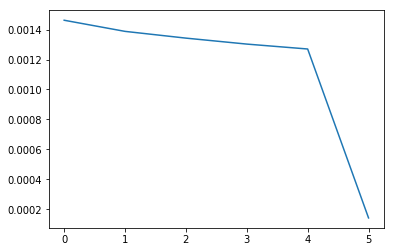

In [409]:
plt.plot(np.arange(len(just_scores[24:30])),(just_scores[24:30]))


In [722]:
scores[24:30]

[[1, 0.001462029804203652, 5],
 [6, 0.0013877529690621115, 95],
 [11, 0.0013427198413541964, 96],
 [16, 0.0013029291315034713, 292],
 [21, 0.0012701763318097284, 243],
 [1, 0.0001431933907664586, 6]]

In [411]:
for i in range(10,101,10):
    iter=i
    print (iter)

10
20
30
40
50
60
70
80
90
100


In [72]:
rebuilt = np.dot(W,H)

NameError: name 'W' is not defined

(73865, 4222)

In [105]:
rebuilt.shape

(73865, 4230)

In [106]:
matrix.shape

(73865, 4230)

In [108]:
rebuilt-matrix

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976971e-04, 3.29969297e-04, 2.11526977e-04, ...,
        1.46095233e-04, 9.08517333e-04, 6.24379430e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05683634e-05, 7.16348659e-05, 8.00710503e-05, ...,
        4.00441875e-05, 2.78065699e-04, 2.19722093e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [121]:
np.mean((rebuilt-matrix)**2)

0.09009532798915376

n_components:
1   =  .0001
2   = 0.0013937693036813904
3   = 0.001383618220432841
10  = 0.0013233378763788833
100 =-0.0003337663571822616
100 = 0.001324181632724416

In [129]:
scorer=metrics.explained_variance_score
prediction = model.inverse_transform(model.transform(sparse_matrix))
scorer(matrix, prediction)

0.018682112359056913

In [130]:
prediction


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29976672e-04, 3.29950574e-04, 2.11518553e-04, ...,
        1.46131375e-04, 9.08533609e-04, 6.24109411e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.05695823e-05, 7.16348761e-05, 8.00711799e-05, ...,
        4.00437082e-05, 2.78061313e-04, 2.19714633e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [51]:
def fit_NMF(sparse_matrix,n_components,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components=1,max_iter=250)

In [52]:
model_iter

5

In [14]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
LDA_model = LDA(n_components=2,max_iter=10)
LDA_W = model.fit_transform(sparse_matrix)
LDA_H = model.components_


In [54]:
list(items_set)[1000]

'NO Hyaluronic Acid'

In [55]:
W

array([[0.00000000e+00, 5.23875209e-05, 1.77303907e-08, ...,
        5.91061811e-06, 2.96486260e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.57673040e-04, 2.54497783e-04, 1.24091042e-04, ...,
        1.37969797e-04, 5.65095952e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.22660450e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.11085688e-04, 2.71493387e-04, 3.85144914e-04, ...,
        1.04055473e-03, 1.16936300e-03, 0.00000000e+00],
       [7.26642345e-03, 1.88590874e-03, 9.48730697e-04, ...,
        0.00000000e+00, 3.19376156e-03, 1.59117436e-03]])

In [53]:
feature_names=list(items_set).copy()
n_top_words=20
for topic in H:
    print(topic.argsort()[:-n_top_words - 1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

[ 5776 10980 11404  5565 10916  4844 12209  9089  7506  9083  3528 11886
  4962 10595  6685  5954 10629  6726  1948  1946]
['ONIONS YELLOW', 'GARLIC WHITE', 'APPLES FUJI', 'CELERY', 'PEPPERS RED BELL', 'CARROTS LOOSE', 'GINGER', 'SQUASH ZUCCHINI', 'LEMONS', 'ORANGES NAVEL', 'CILANTRO', 'KALE DINO', 'ONIONS RED', 'BROCCOLI LOOSE', 'LIMES', 'SATSUMA MANDARIN', 'MUSHROOM CRIMINI', 'ONIONS GREEN', 'CARROTS BUNCH', 'PEPPER CHILI']



Topic #0:
['GARLIC WHITE', 'GINGER', 'SHALLOTS', 'ONIONS RED', 'MUSHROOM CRIMINI', 'MUSHROOMS SHIITAKE', 'ROOT TURMERIC', 'ONIONS WHITE', '5290 WALNUTS', 'PARMIGIANO REGG', 'IVY CHEDDAR', '5120 ORG ALMONDS', 'LEMONS MEYER', '3680 BAKERS CH FLO', 'BOK CHOY BABY', 'HERBS BASIL', 'PAREGGIO', 'HERBS BUNCH', '2220 ORG RED LNTL', 'POTATOES JAPANESE', '2195 ORG GARBANZO', '4110org rolledOATS', '6645 SUNFLWR SEEDS', 'SHIITAKES BABY', '8571 TURM PWD ORG']


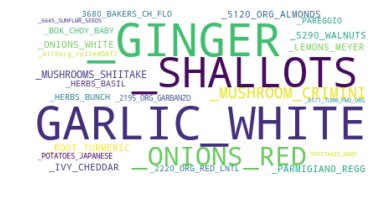

<img src="./img/2018/10/month.topic0.png">
Topic #1:
['APPLES FUJI', 'PLUOT/PLUM RED', 'PEAR BARTLETT', 'PERSIMMONS FUYU', 'GRAPES RED', 'ORANGES VALENCIA', 'GRAPES GREEN', 'POMEGRANATES', 'IVY CHEDDAR', 'BAGEL', '5290 WALNUTS', 'PEARS RED', '5120 ORG ALMONDS', '4110org rolledOATS', 'PEAR BOSC', '3185 ORG MANGO', 'CUKE MEDIT/PERSIAN', 'KIWI LOOSE', 'POTATOES JAPANESE', 'PAREGGIO', 'POTATOES GARNET', 'CARROTS BUNCH', 'REFRIGERATED', 'GRAPEFRUIT', 'PEAR BROWN ASIAN']


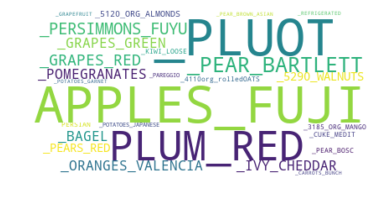

<img src="./img/2018/10/month.topic1.png">
Topic #2:
['TOMATO DRY FARM', 'HERBS BASIL', 'CUKE MEDIT/PERSIAN', 'PLUOT/PLUM RED', 'CORN', 'ARUGULA LOOSE', 'LETTUCE SALAD MIX', 'BAGEL', 'IVY CHEDDAR', 'PAREGGIO', 'LETTUCE RED LEAF', 'LIL GEM LETTUCE', 'LETTUCE ROMAINE', 'PT REYES MOZZARELL', 'NECTARINE', '2448 CASTEL OLIVE', 'LETTUCE RED BUTTER', 'FIGS BLACK', 'RADISHES RED/FRENC', 'GRAPEFRUIT', 'MUSHROOMS SHIITAKE', '2450 KALAMATA-PIT', 'EGGPLANT GLOBE', 'BELFIORE CILIEGINI', 'POTATOES RUSSET']


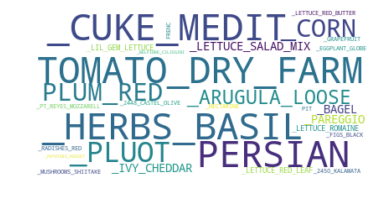

<img src="./img/2018/10/month.topic2.png">
Topic #3:
['LEMONS', 'LIMES', 'ORANGES VALENCIA', 'KALE DINO', 'GINGER', 'CUCUMBERS', 'GRAPEFRUIT', 'SHALLOTS', 'BROCCOLI BABY SWEE', '5290 WALNUTS', 'HERBS BUNCH', 'PARSLEY ITALIAN', 'ARUGULA LOOSE', 'FENNEL', 'BLUEBERRY', 'PLUOT/PLUM RED', 'PARMIGIANO REGG', 'PERSIMMONS FUYU', 'SQUASH DELICATA', 'LETTUCE SALAD MIX', 'POTATOES GARNET', 'ROOT TURMERIC', '2448 CASTEL OLIVE', 'POMEGRANATES', 'CLO UNSALTED BUTTE']


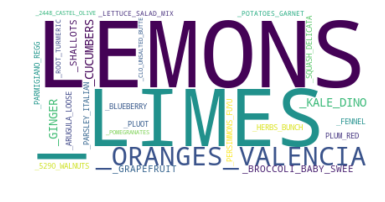

<img src="./img/2018/10/month.topic3.png">
Topic #4:
['CELERY', 'CARROTS LOOSE', 'CUCUMBERS', 'BEETS RED LOOSE', 'PARSLEY ITALIAN', 'KALE DINO', 'LEEKS', 'LETTUCE SALAD MIX', 'CABBAGE GREEN', 'POTATOES RUSSET', 'KALE GREEN', 'BROCCOLI LOOSE', 'POTATOES RED', 'GINGER', 'ONIONS GREEN', 'COLLARDS', 'PEPPERS GREEN BELL', 'DANDELION', 'ROOT TURMERIC', 'LETTUCE ROMAINE', 'CABBAGE RED', 'POTATOES YELLOW', 'PARSLEY CURLY', 'ORANGES VALENCIA', 'LETTUCE RED LEAF']


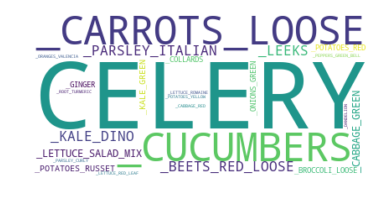

<img src="./img/2018/10/month.topic4.png">
Topic #5:
['ONIONS YELLOW', 'POTATOES YELLOW', 'POTATOES GARNET', 'POTATOES RUSSET', 'POTATOES JAPANESE', 'SQUASH BUTTERNUT', 'CARROTS BUNCH', 'LEEKS', 'PEPPERS GREEN BELL', 'TOMATOES ROMA', 'SQUASH DELICATA', 'BRUSSEL SPROUTS', 'CARROTS LOOSE', 'PARMIGIANO REGG', 'STRAUS PLN YOG QT', 'MUSHROOMS SHIITAKE', 'MUSHROOM CRIMINI', 'ONIONS GREEN', 'EGGS JUDY LG DZ', '2220 ORG RED LNTL', 'WHOLE ORG MILK', 'PARSLEY ITALIAN', 'CABBAGE GREEN', 'POTATOES RED', 'CAULIFLOWER CELLO']


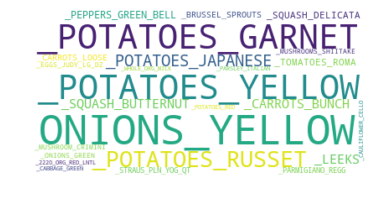

<img src="./img/2018/10/month.topic5.png">
Topic #6:
['1lb STRAWBERRY', 'BLUEBERRY', 'PLUOT/PLUM RED', 'GRAPES RED', 'NECTARINE', 'BLACKBERRY PACK', 'BAGEL', 'ORANGES VALENCIA', 'PEAR BARTLETT', 'CORN', 'MANGO', 'PLUMS BLACK', 'GRAPES GREEN', 'APPLES GALA', 'TOMATO MIX HEIRLOO', 'REFRIGERATED', 'FIGS BLACK', 'BLACKBERRY PACKAGE', 'PAREGGIO', 'KIWI LOOSE', 'MINI SEEDLESS H20', 'MELON CANTALOUPE/H', 'CUCUMBERS', '3185 ORG MANGO', 'RASPBERRY PACK']


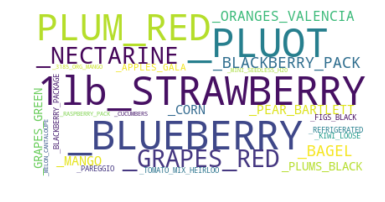

<img src="./img/2018/10/month.topic6.png">
Topic #7:
['CILANTRO', 'PEPPER CHILI', 'LIMES', 'ONIONS GREEN', 'PARSLEY ITALIAN', 'HERBS BUNCH', 'HERBS BASIL', 'GINGER', 'SHALLOTS', 'TOMATO MIX HEIRLOO', 'DILL', 'CUKE MEDIT/PERSIAN', 'ONIONS RED', 'CARROTS BUNCH', 'RADISHES RED/FRENC', 'POMEGRANATES', 'ONIONS WHITE', 'PERSIMMONS FUYU', 'CABBAGE RED', 'LEMONS MEYER', 'CABBAGE GREEN', 'DANDELION', 'ROOT TURMERIC', 'MUSHROOMS SHIITAKE', 'LEEKS']


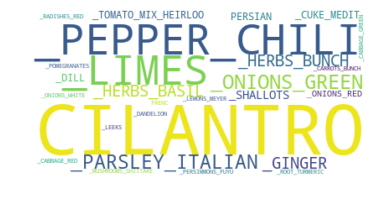

<img src="./img/2018/10/month.topic7.png">
Topic #8:
['PEPPERS RED BELL', 'ONIONS RED', 'PEPPERS GREEN BELL', 'CUCUMBERS', 'MUSHROOM CRIMINI', 'PEPPERS ORANGE BEL', 'PEPPERS YELLOW BEL', 'EGGPLANT GLOBE', 'TOMATOES ROMA', 'LETTUCE SALAD MIX', 'POTATOES GARNET', 'PEPPER CHILI', 'SUGAR PLUM CLAM', 'GRAPES RED', 'CABBAGE RED', 'CUKE MEDIT/PERSIAN', 'LETTUCE ROMAINE', 'ONIONS WHITE', 'CARROTS LOOSE', 'TOMATO', '2450 KALAMATA-PIT', 'GREEN ONIONS', 'LETTUCE GREEN LEAF', 'CARROTS BABY', 'POTATOES RED']


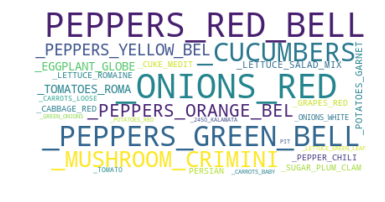

<img src="./img/2018/10/month.topic8.png">
Topic #9:
['SQUASH ZUCCHINI', 'BEANS GREEN', 'CARROTS BUNCH', 'KALE DINO', 'SPINACH LOOSE', 'BROCCOLI LOOSE', 'MUSHROOM CRIMINI', 'CORN', 'ARUGULA LOOSE', 'POTATOES GARNET', 'LETTUCE SALAD MIX', 'TOMATO MIX HEIRLOO', 'CUKE MEDIT/PERSIAN', '5290 WALNUTS', 'GRAPES RED', 'PERSIMMONS FUYU', 'HERBS BASIL', '4110org rolledOATS', 'POTATOES YELLOW', 'BROCCOLI BABY SWEE', 'CAULIFLOWER CELLO', 'MUSHROOMS SHIITAKE', 'PLUOT/PLUM RED', 'PEAR BARTLETT', 'CUCUMBERS']


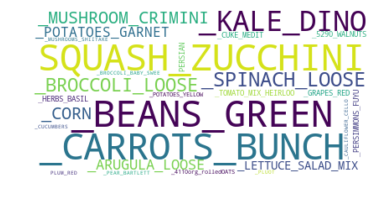

<img src="./img/2018/10/month.topic9.png">


In [41]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics =[]
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics.append(topic_string)
        print(topic_string)
        #print()
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('./img/2018/10/month.topic%d.png'%topic_idx)
        print('<img src="./img/2018/10/month.topic%d.png">'%topic_idx)
    return topic_dict
topics = print_top_items(model,list(items_set),25)
#print("stopwords:",stopwords,"number of topics:",len(topics))

In [42]:
topics3=topics.copy()

In [43]:
topic_compare =np.zeros([len(topics),len(topics)])

for topic in topics:
    for item in topics[topic]:
        for topic2 in topics:
            #print (item)
            #print (type(topics[topic2]))
            if item in topics[topic2]:
                topic_compare[topic,topic2]+=1
            
print(topic_compare)


[[25.  6.  4.  6.  2.  5.  1.  9.  3.  5.]
 [ 6. 25.  6.  7.  1.  3. 10.  4.  3.  9.]
 [ 4.  6. 25.  5.  4.  2.  6.  4.  5.  7.]
 [ 6.  7.  5. 25.  7.  4.  4.  8.  3.  9.]
 [ 2.  1.  4.  7. 25.  9.  2.  8.  7.  5.]
 [ 5.  3.  2.  4.  9. 25.  0.  6.  6.  6.]
 [ 1. 10.  6.  4.  2.  0. 25.  1.  2.  6.]
 [ 9.  4.  4.  8.  8.  6.  1. 25.  5.  6.]
 [ 3.  3.  5.  3.  7.  6.  2.  5. 25.  6.]
 [ 5.  9.  7.  9.  5.  6.  6.  6.  6. 25.]]


In [39]:
list_of_topics=[]
for topic in topics:
     list_of_topics.append(topics[topic])

In [40]:
len(topics[0])

25

In [41]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

row 0
row 1
iI 0 APPLES FUJI
iI 1 PEAR BOSC
iI 2 KIWI LOOSE
iI 3 ORANGES VALENCIA
iI 4 PEARS RED
iI 5 GRAPEFRUIT
iI 7 TANGELO MINNEOLA
iI 8 CARA CARA NAVEL
iI 10 PARADISO VINTAGE
iI 11 3185 ORG MANGO
iI 12 MILTON CHEDDAR
iI 13 EGGS DZ ST JOHN
iI 14 5290 WALNUTS
iI 15 3080 MEDJOOL DATES
iI 16 ORANGES BLOOD
iI 17 LETTUCE RED LEAF
iI 18 STRAUS MILK 64oz
iI 19 LETTUCE RED BUTTER
iI 20 5120 ORG ALMONDS
iI 21 POTATOES RUSSET
iI 24 CLEMENTINE TANGERI
row 2
iI 0 ONIONS YELLOW
iI 1 POTATOES YELLOW
iI 2 POTATOES RUSSET
iI 3 MUSHROOM CRIMINI
iI 5 LEEKS
iI 6 SHALLOTS
iI 9 PEPPERS GREEN BELL
iI 10 ROOTS PARSNIP
iI 12 EGGS DZ ST JOHN
iI 13 3680 BAKERS CH FLO
iI 14 STRAUS PLN YOG QT
iI 15 8036 BAY LEAF ORG
iI 16 EGGPLANT GLOBE
iI 17 MILTON CHEDDAR
iI 18 PARMIGIANO REGG
iI 19 ORG 1LB BUTTER
iI 20 2220 ORG RED LNTL
iI 21 POTATOES FINGERLIN
iI 22 GARLIC PURPLE
iI 24 BEETS GOLD LOOSE
row 3
iI 0 GARLIC WHITE
iI 1 SHALLOTS
iI 2 MUSHROOM CRIMINI
iI 3 ONIONS WHITE
iI 5 PARMIGIANO REGG
iI 6 POTATOES RUSSET
iI

array([16, 25])

In [42]:
len(ing_set)

NameError: name 'ing_set' is not defined

In [225]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [231]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [233]:
ingredients.shape

(5, 55)

In [234]:
ing_matrix=np.zeros(ingredients.shape)

In [244]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

array([[ 63.,  99.,  42.,  64., 112.,  14.,  21., 124.,  32.,  35.,  88.,
         68., 121., 130., 113., 120.,  38.,  95., 134.,  10.,  23.,  16.,
         27.,  41.,  96., 118.,  58., 101., 105.,  85.,  97.,  47.,  86.,
         29.,  20.,  91.,  15.,  55., 102.,  28.,  98.,   1., 119., 122.,
        132.,  11., 128.,  65.,  17.,  72.,  54.,   0.,  81., 125.,  25.],
       [100.,  32.,  64.,  19.,  88.,   1., 120.,  86.,   3.,   9.,  39.,
        105., 134.,  41.,  78.,  69.,  93., 131., 124.,  48.,  34.,  97.,
         67.,  57., 112.,  62.,  74.,   7.,  16.,  44., 115.,  91.,  65.,
         11., 123.,  14.,  68.,  53., 107.,  51.,  31.,   6.,  98., 102.,
         24., 121.,  61.,  49.,  55.,  12.,  82., 101., 133.,  60.,  75.],
       [ 37., 115.,  96.,  97.,  21.,   1.,  58.,  77.,  35.,   3., 105.,
        118.,  71., 130.,  85., 131., 104.,  87.,  19.,  15.,  43.,  38.,
        101.,   0.,  41.,   2.,  13., 127.,  62., 121.,  18.,  89.,  32.,
        102.,  50., 126.,  65.,  30.

In [255]:
ing_array=ing_index_dict.values()

ing_array

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134])

In [259]:
for i in ing_matrix:
    print(ing_array==i)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

In [226]:
for ing_index_dict

{'SPINACH BUNCHED': 0,
 'POTATOES YELLOW': 1,
 'ROOTS TURNIP LOOSE': 2,
 'POTATOES RUSSET': 3,
 'SATSUMA MANDARIN': 4,
 'ORGANIC 2% MILK': 5,
 'PARMIGIANO REGGIAN': 6,
 'ORG 1LB BUTTER': 7,
 'BAG PINK LADY APPL': 8,
 '4110 ORG RLD OATS': 9,
 'TOMATO MIX HEIRLOO': 10,
 'GREEN ONIONS': 11,
 'BRUSSEL SPROUTS': 12,
 'PEAR BOSC': 13,
 'ONIONS GREEN': 14,
 'KALE GREEN': 15,
 'ORANGES BLOOD': 16,
 'CHARD RAINBOW': 17,
 'POTATOES RED': 18,
 'MUSHROOM CRIMINI': 19,
 'CUCUMBERS ENGLISH': 20,
 'PARSLEY ITALIAN': 21,
 'BLUEBERRIES': 22,
 'BROCCOLI BABY SWEE': 23,
 'CLO UNSALTED BUTTE': 24,
 'DAIKON WATERMELON': 25,
 '2215 ORGANIC LENTI': 26,
 'GRAPEFRUIT': 27,
 'RADDICHIO': 28,
 'BOK CHOY BABY': 29,
 'PEPPERS GREEN BELL': 30,
 'ORG WM QT CLOVER': 31,
 'ONIONS RED': 32,
 'STRAUS PLN YOG QT': 33,
 'EGGS DZ ST JOHN': 34,
 'KALE DINO': 35,
 '3080 MEDJOOL DATES': 36,
 'CELERY': 37,
 'CAULIFLOWER CELLO': 38,
 'EGGPLANT GLOBE': 39,
 'DAIKON': 40,
 'TOMATOES ROMA': 41,
 'LIMES': 42,
 'CHARD RED': 43,
 'BA

In [43]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [44]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

++++++++++++++++++Topic #0, basket #1+++++++++++++++++++
item: ['', 'SR Echinacea Purpu', 12.31, 1]
item: ['', 'Now Elderberry Ext', 12.0, 1]
item: ['', 'GINGER', 1.65, 12]
item: ['', 'KALE RED BOR', 2.49, 12]
item: ['', '8457 PSYLLIUM HUSK', 15.6, 31]
item: ['', 'CELERY', 4.87, 12]
item: ['', 'KALE RED RUSSIAN', 1.99, 12]
item: ['', '6556 DUTCH COCOA', 2.59, 16]
item: ['', 'LEMONS', 3.89, 12]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', '4oz plstc sqz t4', 0.5, 4]
item: ['', 'COLLARDS', 2.49, 12]
item: ['', 'APPLE HONEYCRISP', 3.83, 12]
item: ['', 'SPROUTS ALFALFA', 2.59, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'GREEN CHARD', 1.99, 12]
item: ['', 'KALE GREEN', 1.99, 12]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'CHARD RED', 1.99, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'SPINACH BUNCHED', 2.99, 12]
item: ['', 'CUCUMBERS', 4.92, 12]
item: ['', 'BEETS RED LOOSE', 3.44, 12]
item: ['', 'KHC GRIZZLY CLAW', 10.89, 15]
item:

++++++++++++++++++Topic #2, basket #1+++++++++++++++++++
item: ['', '5357 SUNBUTTER', 15.82, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'CHARD RAINBOW', 1.99, 12]
item: ['', 'APPLES PINK LADY', 6.31, 12]
item: ['', 'POTATOES YELLOW', 16.88, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'BANANAS', 12.81, 12]
item: ['', 'WW LAVASH', 2.89, 17]
item: ['', 'SAVORY BAKED TOFU', 45.24, 13]
item: ['', 'PURPLE SWT POTATO', 14.8, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'POTATOES RUSSET', 2.39, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'EGGPLANT GLOBE', 2.66, 12]
item: ['', 'ONIONS YELLOW', 0.9, 12]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'LEEKS', 5.5600000000000005, 12]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'NWMN VAN CREME CKY', 2.99, 15]
item: ['', 'FAKIN BACON', 4.99, 13]
item: ['VD', 'FAKIN BACON', -4.99, 13]
item: ['', 'FAKIN BACON', 53.88, 13]
item: ['', 'CAULIFLOWER BULK', 11.18, 12]
ite

item: ['', 'TRADITIONAL TORTIL', 5.19, 17]
item: ['', 'SQUASH DELICATA', 2.29, 12]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 4.99, 6]
item: ['', 'PYREX 2C CONTAINER', 19.96, 6]
item: ['', 'PARSLEY CURLY', 1.99, 12]
item: ['', 'EGGS DZ ST JOHN', 7.29, 13]
item: ['', 'GARLIC WHITE', 1.4, 12]
item: ['', 'BEETS RED LOOSE', 1.6099999999999999, 12]
item: ['', 'KIWI LOOSE', 2.69, 12]
item: ['', 'TOMATOES ROMA', 2.67, 12]
item: ['', 'CELERY', 3.88, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'CILANTRO', 1.99, 12]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['', 'FLAVORG VANILLA4oz', 15.49, 15]
item: ['VD', 'FLAVORG VANILLA4oz', -15.49, 15]
item: ['', 'FENNEL', 2.03, 12]
item: ['', 'TOMATOES CLUSTER', 4.19, 12]
item: ['', 'MUSHROOM CRIMINI', 11.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', '2552 OLIVES wCUMI', 1.8599999999999999, 16]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', 'APPLES FUJI', 6.97, 12]
item: ['', 'HERB

item: ['', '3685 WW BREAD FLOU', 3.88, 16]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['MP', 'BAG CREDIT', -0.9500000000000001, 23]
item: ['', '2235 ORG BABY LIMA', 2.51, 16]
item: ['', 'WOOD ALMD BUTTER', 11.49, 15]
item: ['', 'STARTER Pastry', 3.49, 17]
item: ['', '5140 TAMARI ALMOND', 6.5600000000000005, 16]
item: ['', '6880 ORG CANE SUGA', 4.64, 16]
item: ['', 'EGGS ST JOHN 6 PK', 4.29, 13]
item: ['', '5670 SAFFLOWER OIL', 2.5300000000000002, 16]
item: ['', '5657 OG OLIVE OIL', 5.93, 16]
item: ['', 'ITALIAN SAUSAGE', 5.39, 13]
item: ['', '2863 BTR CHOC CHIP', 4.33, 16]
item: ['', '2430 KALAMATA OLIV', 4.05, 16]
item: ['', 'PEAR BOSC', 4.14, 12]
item: ['', 'ONIONS YELLOW', 0.5700000000000001, 12]
item: ['', 'GRAPEFRUIT', 7.9, 12]
item: ['', 'GARLIC WHITE', 1.33, 12]
item: ['', 'HERITAGE FLAKE bag', 9.99, 15]
item: ['', 'APPLES PINK LADY', 7.12, 12]
item: ['', 'APPLES FUJI', 6.73, 12]
item: ['', 'GINGER', 1.15, 12]
item: ['', 'FREY RED TABLE WIN', 9.99, 10]
item: ['', 'CAL OLIVE OIL

item: ['', '8556TURMERICCOCO', 11.04, 11]
item: ['MP', 'BAG CREDIT', -0.05, 23]
item: ['', 'GINGER', 0.35000000000000003, 12]
++++++++++++++++++Topic #8, basket #4+++++++++++++++++++
item: ['', 'TOBYS TOFU DIP', 7.18, 13]
item: ['', 'Henna Gold Cond', 8.95, 4]
item: ['', 'Henna Gold Shampoo', 8.95, 4]
item: ['', 'GOPI PANEER', 6.89, 14]
item: ['', 'TOFURKY SPINA SAUS', 5.39, 13]
item: ['', 'GARD BEEFLESS BURG', 5.49, 19]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'NOCCIOLATA', 6.99, 15]
item: ['', 'SQUASH DELICATA', 7.32, 12]
item: ['', 'BUNCH SPINACH', 7.58, 12]
item: ['', 'PLAIN NAAN', 4.99, 17]
item: ['', 'CARROTS LOOSE', 2.05, 12]
item: ['', 'CALIFIA UNSWT', 4.69, 13]
item: ['', 'LARGE COOLER CRV', 0.1, 13]
item: ['', 'STRAU GREEK YOGURT', 8.69, 13]
item: ['', 'STRAUS PLN YOG QT', 5.39, 13]
item: ['', 'BEYOND BURGER', 6.69, 13]
item: ['', 'PARADISO VINTAGE', 5.22, 14]
item: ['', 'ITALIAN MONTASIO', 4.95, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]
item: ['', 'GUAVA PASTE', 0.99, 14]

item: ['', 'BAMBU PAN SCRAPER', 1.99, 6]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'AVOCADOS HASS', 1.6800000000000002, 12]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2448 CASTEL OLIVE', 3.6, 16]
item: ['', 'GOOD CULTR PINA', 1.79, 13]
item: ['', 'STICK INCENSE', 9.95, 8]
item: ['', 'Qualita Oro Espres', 9.59, 15]
item: ['', 'FRANK MYRRH', 9.95, 8]
item: ['', 'SOY CANDLE TRAVEL', 3.75, 7]
item: ['', 'ORANGES BLOOD', 1.04, 12]
item: ['', 'GOOD CUL STRAW', 1.79, 13]
item: ['', 'FLORAL SAGE BUNDLE', 10.25, 8]
item: ['', 'AROMATHERAPY TIN', 4.59, 7]
item: ['', '8 OZ BIO TUB t3', 0.30000000000000004, 36]
item: ['', '2458 PITD GRN OLIV', 3.42, 16]
item: ['', 'PEAR BOSC', 0.88, 12]
item: ['', 'LIMES', 0.6900000000000001, 12]
item: ['MR', 'SF Bag Charge', 0.4, 20]
++++++++++++++++++Topic #9, basket #10+++++++++++++++++++
item: ['', 'BL FlaxOil 32oz Li', 39.71, 1]
item: ['', 'BLACKBERRY SPREAD', 3.39, 15]
item: ['', 'Unsalted Virginia', 6.29, 15]
item: ['MP', 'BA

item: ['', 'LL TOFU PUPS', 4.29, 13]
item: ['', 'FROZEN SOBA NOODLE', 5.59, 19]
item: ['', 'OG KETCHUP', 4.49, 15]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', 'SPROUTED SILKEN TO', 2.39, 13]
item: ['', '3120 DRD APRICOT', 13.96, 16]
item: ['', 'AVOCADOS HASS', 7.62, 12]
item: ['', 'SQUASH ZUCCHINI', 2.91, 12]
item: ['', 'MUSHROOMS KING TRU', 11.05, 12]
item: ['', 'MEDIUM TOFU', 2.39, 13]
item: ['', '5 LB SUSHI RICE', 11.59, 16]
item: ['', 'BOK CHOY BABY', 3.23, 12]
item: ['', 'GINGER PEACH GREEN', 2.99, 15]
++++++++++++++++++Topic #11, basket #4+++++++++++++++++++
item: ['', 'Bulk Soap', 1.9500000000000002, 4]
item: ['', 'BEANS GREEN', 1.35, 12]
item: ['', 'DILL', 2.99, 12]
item: ['', 'CABBAGE GREEN', 1.76, 12]
item: ['', 'LEEKS', 1.67, 12]
item: ['', 'DAIKON', 1.25, 12]
item: ['', 'PARSLEY ITALIAN', 1.99, 12]
item: ['', 'CELERY', 1.18, 12]
item: ['', 'CADIA TOM PASTE', 1.3900000000000001, 15]
item: ['', 'BEETS RED LOOSE', 3.1, 12]
item: ['', 'SQUASH ZUCCHINI', 1.92, 12]
item

item: ['', 'RASPBERRY', 6.99, 12]
item: ['', 'SUGAR PLUM CLAM', 1.99, 12]
item: ['', 'BROCCOLI BABY SWEE', 3.29, 12]
item: ['', 'BANANAS', 1.45, 12]
item: ['', 'KALE DINO', 1.99, 12]
item: ['', 'AVOCADOS HASS', 4.79, 12]
item: ['', 'TOMATO MIX HEIRLOO', 10.68, 12]
item: ['', 'POTATOES YELLOW', 1.24, 12]
item: ['', 'PEAR BOSC', 0.76, 12]
item: ['', 'POTATOES RED', 1.18, 12]
item: ['MP', 'BAG CREDIT', -0.1, 23]
++++++++++++++++++Topic #13, basket #2+++++++++++++++++++
item: ['', 'AMY RED CURRY THAI', 6.09, 19]
item: ['', 'AMY GRN CURRY ENTR', 6.09, 19]
item: ['', 'BLACK BEAN ENCHILA', 6.09, 19]
item: ['', 'AMY MATTAR TOFU', 6.09, 19]
item: ['', 'CONV GALLON CLOVER', 5.09, 13]
item: ['', 'SAVVY SANDWICH', 4.59, 13]
item: ['', 'CHEESE ENCHILAD ME', 6.09, 19]
item: ['', 'AMY MATTAR PANEER', 6.09, 19]
item: ['', '10% GREEK YOGURT', 8.29, 13]
item: ['', 'FILTER CONE', 2.99, 6]
item: ['', 'BAGEL', 5.0, 17]
item: ['', 'BOK CHOY', 4.72, 12]
item: ['', 'YAYAS CHEESE POPCO', 5.38, 15]
item: ['', '

item: ['', 'RN Extra 50B Go 30', 33.99, 1]
item: ['', 'CSECRET AMINOS 8oz', 5.99, 15]
item: ['', 'GRAPEFRUIT', 3.16, 12]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'WILD 2 PACK', 2.59, 13]
item: ['', 'POTATOES YELLOW', 3.5300000000000002, 12]
item: ['', 'EDEN BLACKBEANS 15', 2.39, 15]
item: ['', 'NORDIC OMEGA 3 PET', 15.99, 7]
item: ['', 'EZ DGL Sugarless 1', 12.95, 1]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'SEA MOBILITY JERKY', 10.59, 7]
item: ['', 'THAI COCONUT MILK', 2.49, 15]
item: ['', 'COOMBS AMBER 12 OZ', 10.39, 15]
item: ['', 'CP BEEF JERKY', 4.99, 7]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'RM CLC POT GNOOCHI', 5.39, 19]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'UE CHOCOCHP COOKIE', 6.29, 15]
item: ['', 'NEWMANS BEEF JERKY', 6.49, 7]
item: ['', 'AVOCADOS HASS', 1.8399999999999999, 12]
item: ['', 'CHAO ORIGINAL', 5.79, 14]
item: ['', 'ASPARAGUS', 6.99, 12]
item: ['', '5140 TAMARI ALMOND', 8.15, 16]
item: ['', 'HERBS BUNCH', 1.69, 12

item: ['', 'RAISED DONUT', 2.69, 17]
item: ['MP', 'BAG CREDIT', -0.1, 23]
item: ['MP', 'BAG CREDIT', -0.1, 23]


In [427]:
df['item_count'].max()

2

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [76]:
len(list(items_set))

6576

In [75]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

[1752 6585 2198 2188 2189 2190 2191 2192 2193 2194]
[1271 6539 4820   80 4966 1929 2604 6546 2660 4806]
[6114 3455  640 2958  537   84 2189 4025 1017 4051]
[3058 2646 2476 5751 5768 6309 4302 4243 3450 6388]
[1484 4994 5017  125 4381  102 1207  435 1811 4079]


In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [72]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

4112 SINTO KIMCHI 13.54
PEPPERS RED BELL 2.75
CUCUMBERS 12.73
ORGANIC 2LB TOFU 20.95
5540 TAHINI 12.17
GINGER 4.79
GARLIC WHITE 3.01
PRODUCE SCALE 1.79
LIMES 2.0
CILANTRO 1.99
CILANTRO 1.99
BROCCOLI LOOSE 6.24
CELLO CAULIFLOWER 11.96
LEEKS 9.12
SUGAR PLUM CLAM 5.97
BEETS RED LOOSE 6.01
store 100% Bulks -34.5
store 100% Produce -70.35
store 100% Refrig -20.95


In [12]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
df['CILANTRO'][10:11]

10    3.98
Name: CILANTRO, dtype: float64

In [19]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.shape

(2535, 6586)

In [22]:
df.to_pickle('02012019.pkl')

In [213]:
len(items_set)

6576

In [114]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]


In [96]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]
[[['', 'BLUEBERRIES', 5.99, 12], ['', 'ALXNDRE YOGURT', 4.99, 13], ['MP', 'Worker 20% Produce', -1.2, 12], ['MP', 'Worker 20% Refrig', -1.0, 13]]]


In [4]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [80]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

['', 'BLUEBERRIES', 5.99, 12]
1 
2 BLUEBERRIES
3 5.99
4 12
['', 'ALXNDRE YOGURT', 4.99, 13]
5 
6 ALXNDRE YOGURT
7 4.99
8 13
['MP', 'Worker 20% Produce', -1.2, 12]
9 MP
10 Worker 20% Produce
11 -1.2
12 12
['MP', 'Worker 20% Refrig', -1.0, 13]
13 MP
14 Worker 20% Refrig
15 -1.0
16 13


NameError: name 'plt' is not defined

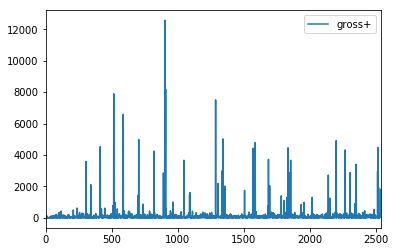

In [51]:
df[['gross+','time']].plot()
plt.show()

In [33]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

yep


In [18]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


f: ('./tlogs', ['201902'], ['.DS_Store']) sub: []
f: ('./tlogs/201902', ['20190202', '20190203', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210', '20190211', '20190212', '20190213', '20190214', '20190215', '20190216', '20190217', '20190218', '20190219', '20190220', '20190221', '20190222', '20190223', '20190224', '20190225', '20190226', '20190227', '20190228', '20190301'], ['.DS_Store']) sub: []
f: ('./tlogs/201902/20190202', [], ['checklisting.txt', 'department.txt', 'Department01Discounts.txt', 'Department04Discounts.txt', 'Department06Discounts.txt', 'Department07Discounts.txt', 'Department08Discounts.txt', 'Department09Discounts.txt', 'Department10Discounts.txt', 'Department11Discounts.txt', 'Department12Discounts.txt', 'Department13Discounts.txt', 'Department14Discounts.txt', 'Department15Discounts.txt', 'Department16Discounts.txt', 'Department17Discounts.txt', 'Department19Discounts.txt', 'Department26Discounts.txt', 'dept.txt', 'discountitems.tx

In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [8]:
df=pd.read_pickle('02012019.pkl')

In [10]:
df[df['BANANAS']!=0]

date  gross+  gross-  \
36   2001-02-19   37.65    0.00   
44   2001-02-19  108.17    0.00   
65   2001-02-19   20.72    0.00   
73   2001-02-19  144.42    0.00   
74   2001-02-19   17.69    0.00   
77   2001-02-19  224.03    0.00   
89   2001-02-19   80.01    0.00   
97   2001-02-19   86.51    0.00   
98   2001-02-19  285.53    0.00   
101  2001-02-19   55.73    0.00   
109  2001-02-19  105.52    0.00   
113  2001-02-19   12.14    0.00   
114  2001-02-19  175.43    0.00   
115  2001-02-19   68.49    0.00   
118  2001-02-19   55.34    0.00   
119  2001-02-19   52.38    0.00   
125  2001-02-19  172.58    0.00   
137  2001-02-19   99.10    2.00   
139  2001-02-19   30.68    0.00   
142  2001-02-19    0.00    0.00   
147  2001-02-19  138.44    0.00   
151  2001-02-19   54.56    0.00   
176  2001-02-19   55.74    0.00   
186  2001-02-19    1.53    0.00   
192  2001-02-19   40.75    0.00   
193  2001-02-19   65.90    0.00   
203  2001-02-19   53.40    0.00   
205  2001-02-19   31.08    0.00   
215  2001-02-19   33.35    0.00   
226  2001-02-19   19.06    0.00   
...         ...     ...     ...   
2332 2001-02-19   45.25    0.00   
2343 2001-02-19   24.27    0.00   
2362 2001-02-19  117.94    5.59   
2363 2001-02-19  102.22    0.00   
2377 2001-02-19  230.36    0.91   
2380 2001-02-19   27.66    0.00   
2385 2001-02-19  147.84    0.00   
2397 2001-02-19   97.99    0.00   
2398 2001-02-19   48.57    0.00   
2400 2001-02-19  353.92    2.00   
2423 2001-02-19   49.31    0.00   
2425 2001-02-19  186.17    0.00   
2437 2001-02-19  108.34    0.00   
2438 2001-02-19   33.28    0.00   
2443 2001-02-19   76.49    0.00   
2446 2001-02-19  157.27    0.00   
2449 2001-02-19   39.03    0.00   
2450 2001-02-19  134.10    0.00   
2453 2001-02-19   83.95    0.00   
2461 2001-02-19  138.24    0.00   
2467 2001-02-19  190.60    0.00   
2475 2001-02-19   36.13    0.00   
2482 2001-02-19   67.24    0.00   
2494 2001-02-19   61.51    0.00   
2496 2001-02-19  131.94    0.00   
2499 2001-02-19   63.32    0.00   
2526 2001-02-19   38.15    0.00   
2529 2001-02-19   22.97    0.00   
2532 2001-02-19   53.25    0.00   
2533 2001-02-19   50.05    0.00   

                                                  items     net  oper  term  \
36    [[, PASCHA UNSWT CCHIP, 4.99, 15], [, PRIMAVER...   37.65   104     5   
44    [[, FORGER PL CSH YOG, 5.59, 13], [, SO DEL UN...  108.17    42     6   
65    [[, APPLES FUJI, 2.42, 12], [, 8308KEEMUN BLAC...   20.72    11     1   
73    [[, WOODSTK BLUEBERRIE, 6.29, 19], [, EVOLUTIO...  144.42    42     6   
74    [[, COELA ZIPPER TOTE, 9.99, 6], [, BANANAS, 2...   17.69    42     6   
77    [[, APPLE JUICE, 11.39, 15], [, ORG GAL CLOVER...  224.03   104     5   
89    [[, MAC HAWAI SEA SALT, 7.99, 15], [, UMLAUT C...   80.01    42     6   
97    [[, FLAVORG VANILLA4oz, 15.49, 15], [, SUGAR P...   86.51    34     8   
98    [[, VH Kids Vibe Choc, 34.4, 1], [, EZ Ultimat...  285.53    11     1   
101   [[, QRT CAN JAR t101, 1.79, 6], [, QRT CAN JAR...   55.73    42     6   
109   [[, SPRTD SEEDS GF BRD, 9.49, 17], [, LUND FIE...  105.52    33     3   
113   [[, BANANAS, 4.11, 12], [, ORGANIC CARROT 16, ...   12.14    11     1   
114   [[, SAN PEL GLASS 1 LT, 2.39, 15], [, CRV LRG ...  175.43    42     6   
115   [[, CHAMELEON VAN 32, 10.19, 13], [, SMALL COO...   68.49    34     8   
118   [[, NV TOILET PAPER 4, 3.85, 7], [, BANANAS, 2...   55.34    11     1   
119   [[, SILK UNSWT SOYMILK, 3.69, 13], [, SILK SOY...   52.38    42     6   
125   [[, RAMEN BROTH, 4.19, 15], [, PHO BROTH, 4.19...  172.58    34     8   
137   [[, STRAUS MILK 32oz, 3.29, 13], [DP, BOTTLE D...   97.10   104     5   
139   [[, STARTER Croissant, 2.99, 17], [, APPLE FRI...   30.68   104     5   
142   [[, CASASAN THIN CHIPS, 3.99, 15], [, SALTED B...    0.00    33     3   
147   [[, CASASAN THIN CHIPS, 3.99, 15], [, SALTED B...  138.44    33     3   
151   [[, SEA SALT CARAMEL, 5.89, 15], [, FENT CHERR...   54.56    42     6   
176   [[, MINERAL WATER

In [200]:
df.columns

Index(['date', 'gross+', 'gross-', 'items', 'net', 'oper', 'term', 'time',
       'trans', 'type'],
      dtype='object')

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [54]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [1]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

NameError: name 'get_dataframe' is not defined

In [11]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

['/Users/Sarah/galvanize/dsi-capstone/jsons/201802/0.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/1.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/2.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/3.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/4.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/5.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/6.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/7.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/8.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/9.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/10.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/11.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/12.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/13.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/14.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/15.json', '/Users/Sarah/galvanize/dsi-capstone/jsons/201802

In [10]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

ValueError: Expected object or value